In [1]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
import numpy as np

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Load file - UPDATE THIS PATH AS NEEDED
# filepath = "finetune_evals/2025-12-03-23-49-37_meta-llama-Meta-Llama-3.1-8B-Instruct_llm_metacognition-wbtl9xqu-step-1280-20251203-224144_TriviaMC_n500_comparison.jsonl"
filepath = "finetune_evals/2025-12-04-00-23-02_meta-llama-Meta-Llama-3.1-8B-Instruct_llm_metacognition-wbtl9xqu-step-1280-20251203-224144_PopMC_0_difficulty_filtered_test_n500_comparison.jsonl"
# filepath = "finetune_evals/2025-12-04-02-49-08_meta-llama-Meta-Llama-3.1-8B-Instruct_llm_metacognition-wbtl9xqu-step-1280-20251203-224144_SimpleMC_n500_comparison.jsonl"

# Read all lines and extract both summaries and sample data
instruct_summary = None
finetuned_summary = None
instruct_samples = []
finetuned_samples = []

with open(filepath, 'r') as f:
    for line in f:
        if line.strip():
            entry = json.loads(line.strip())
            entry_type = entry.get('type', '')
            if entry_type == 'instruct_eval_summary':
                instruct_summary = entry
            elif entry_type == 'finetuned_eval_summary':
                finetuned_summary = entry
            elif entry_type == 'instruct_eval_sample':
                instruct_samples.append(entry)
            elif entry_type == 'finetuned_eval_sample':
                finetuned_samples.append(entry)

# Fallback: if no prefixes found, check for regular eval_summary (backward compatibility)
if instruct_summary is None and finetuned_summary is None:
    with open(filepath, 'r') as f:
        lines = f.readlines()
        last_line = lines[-1].strip()
        eval_summary = json.loads(last_line)
        if eval_summary.get('type') == 'eval_summary':
            finetuned_summary = eval_summary
            print("⚠️  Only found one eval_summary (no prefixes). Assuming it's finetuned model.")
else:
    eval_summary = finetuned_summary  # For backward compatibility with existing code

print("Loaded eval summaries:")
if instruct_summary:
    print(f"  ✓ Instruct (base) model: {instruct_summary.get('n_samples')} samples, Accuracy: {instruct_summary.get('mcq_accuracy', 0):.4f}")
if finetuned_summary:
    print(f"  ✓ Finetuned model: {finetuned_summary.get('n_samples')} samples, Accuracy: {finetuned_summary.get('mcq_accuracy', 0):.4f}")
if not instruct_summary and not finetuned_summary:
    print("  ❌ No eval_summary entries found!")

print(f"\nLoaded sample data:")
print(f"  ✓ Instruct samples: {len(instruct_samples)}")
print(f"  ✓ Finetuned samples: {len(finetuned_samples)}")

# Extract model and dataset info from filepath
def extract_model_dataset_info(filepath):
    """Extract model and dataset names from filepath."""
    path = Path(filepath)
    filename = path.stem  # Get filename without extension
    
    # Parse filename format: {timestamp}_{base_model}_{lora_name}_{dataset_name}_n{num}_comparison.jsonl
    # or: {timestamp}_{base_model}_{lora_name}_{dataset_name}_n{num}.jsonl
    parts = filename.split('_')
    
    # Find base model (starts with 'meta-llama' or similar)
    base_model = None
    lora_name = None
    dataset_name = None
    
    # Look for base model pattern - it's usually a single part like "meta-llama-Meta-Llama-3.1-8B-Instruct"
    # or could be split across parts
    for i, part in enumerate(parts):
        if 'llama' in part.lower() and 'meta' in part.lower():
            # This is likely the full model name in one part
            base_model = part
            break
        elif part.lower() == 'meta' and i + 1 < len(parts) and 'llama' in parts[i+1].lower():
            # Model name might be split - collect parts
            model_parts = [parts[i], parts[i+1]]
            for j in range(i+2, min(i+8, len(parts))):
                # Stop if we hit something that looks like LoRA (metacognition, wbtl, etc.) or dataset
                if any(x in parts[j].lower() for x in ['metacognition', 'wbtl', 'ect', 'step', 'llm']):
                    break
                if parts[j].lower() in ['popmc', 'triviamc', 'simplemc', 'comparison']:
                    break
                if parts[j].startswith('n') and parts[j][1:].isdigit():
                    break
                model_parts.append(parts[j])
            base_model = '-'.join(model_parts)
            break
    
    # Look for dataset name (usually before 'n{num}' or at the end)
    # Common patterns: PopMC, TriviaMC, SimpleMC, etc.
    for i, part in enumerate(parts):
        if part.lower().startswith('popmc') or part.lower().startswith('triviamc') or part.lower().startswith('simplemc'):
            dataset_name = part
            break
        elif 'mc' in part.lower() and len(part) > 3:
            dataset_name = part
            break
    
    # Look for lora name (usually between base model and dataset)
    # It might contain 'llm-metacognition' or similar
    for i, part in enumerate(parts):
        if 'metacognition' in part.lower() or 'ect' in part.lower() or 'wbtl' in part.lower():
            # Lora name might span multiple parts
            lora_parts = []
            for j in range(i, min(i+5, len(parts))):
                if parts[j].startswith('n') and parts[j][1:].isdigit():
                    break
                if parts[j].lower() in ['popmc', 'triviamc', 'simplemc', 'comparison']:
                    break
                lora_parts.append(parts[j])
            if lora_parts:
                lora_name = '-'.join(lora_parts)
            break
    
    # Fallback: try to extract from filename more generically
    if not base_model:
        # Look for parts that look like model names
        for part in parts:
            if 'llama' in part.lower() or 'gpt' in part.lower() or 'instruct' in part.lower():
                base_model = part
                break
    
    if not dataset_name:
        # Try to find dataset name before 'n{num}'
        for i, part in enumerate(parts):
            if part.startswith('n') and part[1:].isdigit():
                if i > 0:
                    dataset_name = parts[i-1]
                break
    
    # Return model name as-is (don't convert to slashes - keep readable format)
    return base_model, lora_name, dataset_name

# Extract model and dataset info from filepath (automatically)
base_model, lora_name, dataset_name = extract_model_dataset_info(filepath)

# Create display strings - YOU CAN EDIT THESE IF NEEDED
if base_model:
    # Keep model name readable (it's already in a good format like "meta-llama-Meta-Llama-3.1-8B-Instruct")
    model_display = base_model
else:
    model_display = "Unknown Model"

if dataset_name:
    dataset_display = dataset_name
else:
    dataset_display = "Unknown Dataset"

# Optional: Override the extracted values if needed
# Uncomment and modify these lines to manually set the values:
# model_display = "Your Model Name Here"
# dataset_display = "Your Dataset Name Here"
# lora_name = "Your LoRA Name Here"  # Optional

print(f"\n📊 Model & Dataset Info (extracted from filename):")
print(f"  Model: {model_display}")
if lora_name:
    print(f"  LoRA Adapter: {lora_name}")
print(f"  Dataset: {dataset_display}")
print(f"\n💡 Tip: You can override these values by editing the variables above.")

# Helper function to add model/dataset info to plots at the top
def add_model_dataset_info(fig, model_display, dataset_display, lora_name=None):
    """Add model and dataset information at the top of a figure in title-sized text."""
    # Create title text
    if lora_name:
        title_text = f"{model_display} (Finetuned) | {dataset_display}"
    else:
        title_text = f"{model_display} | {dataset_display}"
    
    # Add title at the top of the figure, centered
    # Use subplots_adjust to make room at the top
    fig.subplots_adjust(top=0.92)  # Make room for the title
    fig.suptitle(title_text, fontsize=14, fontweight='bold', y=0.98, ha='center')

Loaded eval summaries:
  ✓ Instruct (base) model: 500 samples, Accuracy: 0.4480
  ✓ Finetuned model: 500 samples, Accuracy: 0.5440

Loaded sample data:
  ✓ Instruct samples: 500
  ✓ Finetuned samples: 500

📊 Model & Dataset Info (extracted from filename):
  Model: meta-llama-Meta-Llama-3.1-8B-Instruct
  LoRA Adapter: metacognition-wbtl9xqu-step-1280-20251203-224144
  Dataset: PopMC

💡 Tip: You can override these values by editing the variables above.


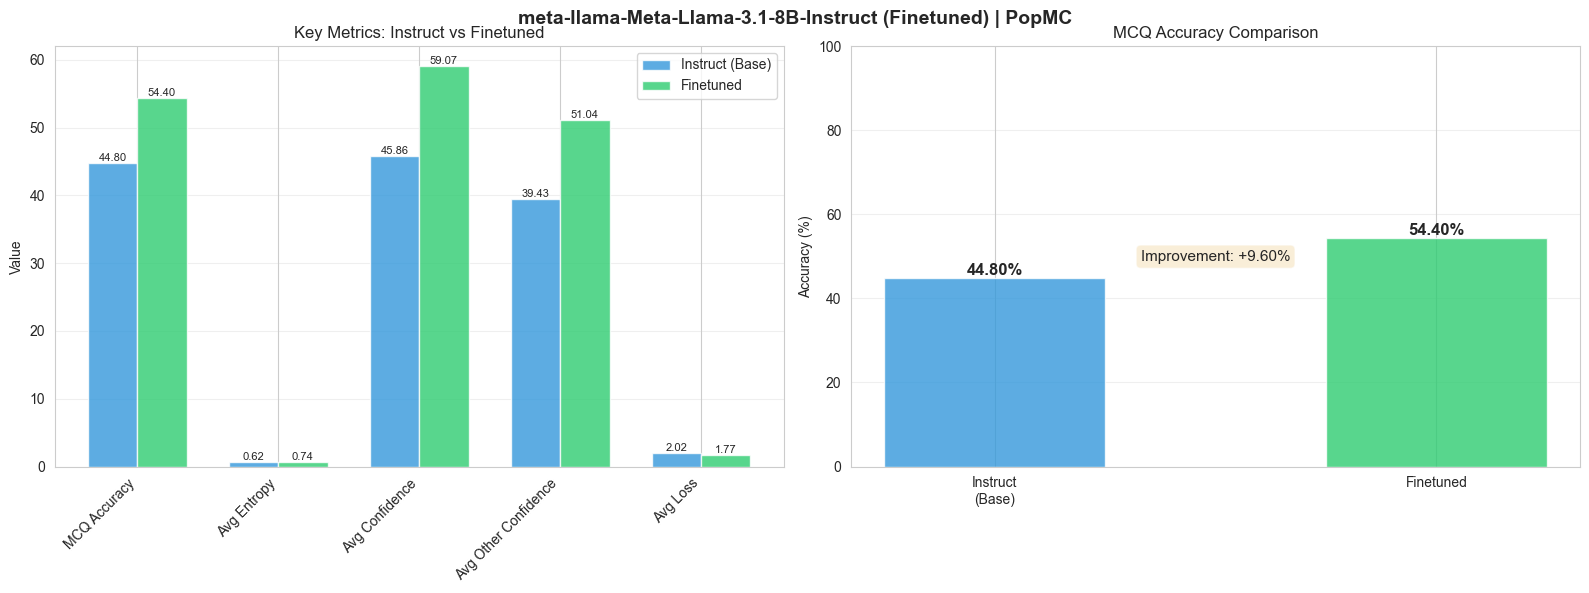

In [2]:
# 1. Main Metrics Comparison (Side-by-Side)
def get_metrics(summary, label):
    if summary is None:
        return None, label
    return {
        'MCQ Accuracy': summary.get('mcq_accuracy', 0) * 100,
        'Avg Entropy': summary.get('avg_entropy', 0),
        'Avg Confidence': summary.get('avg_confidence', 0),
        'Avg Other Confidence': summary.get('avg_other_confidence', 0),
        'Avg Loss': summary.get('avg_loss', 0),
    }, label

instruct_metrics, _ = get_metrics(instruct_summary, 'Instruct')
finetuned_metrics, _ = get_metrics(finetuned_summary, 'Finetuned')

if instruct_summary and finetuned_summary:
    # Side-by-side comparison
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    metric_names = ['MCQ Accuracy', 'Avg Entropy', 'Avg Confidence', 'Avg Other Confidence', 'Avg Loss']
    x = range(len(metric_names))
    width = 0.35
    
    instruct_vals = [instruct_metrics.get(m, 0) for m in metric_names]
    finetuned_vals = [finetuned_metrics.get(m, 0) for m in metric_names]
    
    ax1 = axes[0]
    ax1.bar([i - width/2 for i in x], instruct_vals, width, label='Instruct (Base)', color='#3498db', alpha=0.8)
    ax1.bar([i + width/2 for i in x], finetuned_vals, width, label='Finetuned', color='#2ecc71', alpha=0.8)
    ax1.set_ylabel('Value')
    ax1.set_title('Key Metrics: Instruct vs Finetuned')
    ax1.set_xticks(x)
    ax1.set_xticklabels(metric_names, rotation=45, ha='right')
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for i, (inst_val, fin_val) in enumerate(zip(instruct_vals, finetuned_vals)):
        ax1.text(i - width/2, inst_val, f'{inst_val:.2f}', ha='center', va='bottom', fontsize=8)
        ax1.text(i + width/2, fin_val, f'{fin_val:.2f}', ha='center', va='bottom', fontsize=8)
    
    # Right: Accuracy comparison
    ax2 = axes[1]
    models = ['Instruct\n(Base)', 'Finetuned']
    accuracies = [instruct_metrics['MCQ Accuracy'], finetuned_metrics['MCQ Accuracy']]
    colors = ['#3498db', '#2ecc71']
    bars = ax2.bar(models, accuracies, color=colors, alpha=0.8, width=0.5)
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('MCQ Accuracy Comparison')
    ax2.set_ylim(0, 100)
    ax2.grid(axis='y', alpha=0.3)
    
    # Add value labels and improvement
    for bar, acc in zip(bars, accuracies):
        ax2.text(bar.get_x() + bar.get_width()/2., acc,
                f'{acc:.2f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    improvement = finetuned_metrics['MCQ Accuracy'] - instruct_metrics['MCQ Accuracy']
    ax2.text(0.5, max(accuracies) * 0.9, f'Improvement: {improvement:+.2f}%',
            ha='center', fontsize=11, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    add_model_dataset_info(fig, model_display, dataset_display, lora_name)
    plt.show()
else:
    # Single model view (backward compatibility)
    summary = finetuned_summary or instruct_summary
    metrics = {
        'MCQ Accuracy': summary.get('mcq_accuracy', 0) * 100,
        'Avg Entropy': summary.get('avg_entropy', 0),
        'Avg Confidence': summary.get('avg_confidence', 0),
        'Avg Other Confidence': summary.get('avg_other_confidence', 0),
        'Avg Loss': summary.get('avg_loss', 0),
    }
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    ax1 = axes[0]
    bars = ax1.bar(metrics.keys(), metrics.values(), color=['#2ecc71', '#3498db', '#9b59b6', '#e74c3c', '#f39c12'])
    ax1.set_ylabel('Value')
    ax1.set_title('Key Evaluation Metrics')
    ax1.tick_params(axis='x', rotation=45)
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.2f}', ha='center', va='bottom', fontsize=9)
    
    ax2 = axes[1]
    ax2.bar(['MCQ Accuracy'], [metrics['MCQ Accuracy']], color='#2ecc71', width=0.3)
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Model Accuracy')
    ax2.set_ylim(0, 100)
    ax2.text(0, metrics['MCQ Accuracy'], f'{metrics["MCQ Accuracy"]:.2f}%',
             ha='center', va='bottom', fontsize=12, fontweight='bold')
    plt.tight_layout()
    add_model_dataset_info(fig, model_display, dataset_display, lora_name)
    plt.show()


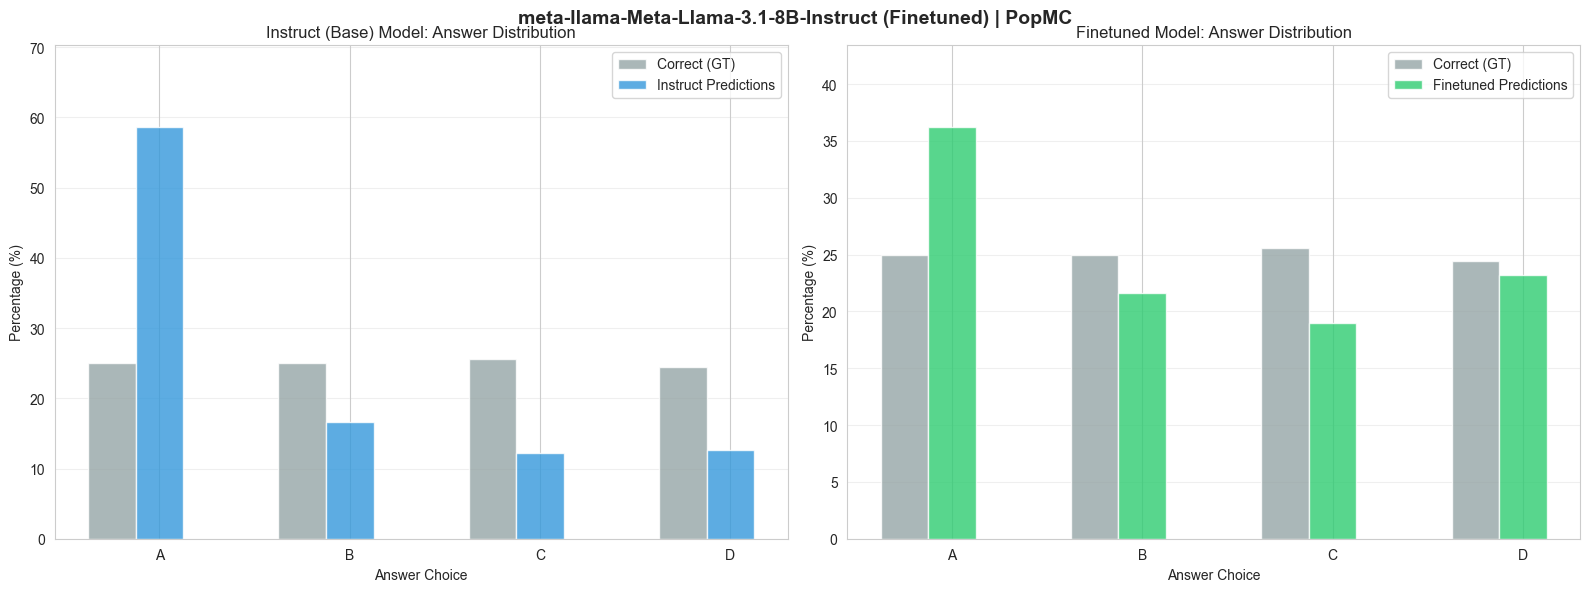

In [3]:
# 2. Answer Distribution Comparison (Side-by-Side)
letters = ['A', 'B', 'C', 'D']

if instruct_summary and finetuned_summary:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Get distributions
    instruct_pred = instruct_summary.get('predicted_answer_distribution_pct', {})
    finetuned_pred = finetuned_summary.get('predicted_answer_distribution_pct', {})
    correct_dist = finetuned_summary.get('correct_answer_distribution_pct', {})  # Same for both
    
    instruct_pred_vals = [instruct_pred.get(letter, 0) for letter in letters]
    finetuned_pred_vals = [finetuned_pred.get(letter, 0) for letter in letters]
    correct_vals = [correct_dist.get(letter, 0) for letter in letters]
    
    x = range(len(letters))
    width = 0.25
    
    # Left: Instruct model
    ax1 = axes[0]
    ax1.bar([i - width for i in x], correct_vals, width, label='Correct (GT)', color='#95a5a6', alpha=0.8)
    ax1.bar(x, instruct_pred_vals, width, label='Instruct Predictions', color='#3498db', alpha=0.8)
    ax1.set_xlabel('Answer Choice')
    ax1.set_ylabel('Percentage (%)')
    ax1.set_title('Instruct (Base) Model: Answer Distribution')
    ax1.set_xticks(x)
    ax1.set_xticklabels(letters)
    ax1.legend()
    ax1.set_ylim(0, max(max(correct_vals), max(instruct_pred_vals)) * 1.2)
    ax1.grid(axis='y', alpha=0.3)
    
    # Right: Finetuned model
    ax2 = axes[1]
    ax2.bar([i - width for i in x], correct_vals, width, label='Correct (GT)', color='#95a5a6', alpha=0.8)
    ax2.bar(x, finetuned_pred_vals, width, label='Finetuned Predictions', color='#2ecc71', alpha=0.8)
    ax2.set_xlabel('Answer Choice')
    ax2.set_ylabel('Percentage (%)')
    ax2.set_title('Finetuned Model: Answer Distribution')
    ax2.set_xticks(x)
    ax2.set_xticklabels(letters)
    ax2.legend()
    ax2.set_ylim(0, max(max(correct_vals), max(finetuned_pred_vals)) * 1.2)
    ax2.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    add_model_dataset_info(fig, model_display, dataset_display, lora_name)
    plt.show()
else:
    # Single model view (backward compatibility)
    summary = finetuned_summary or instruct_summary
    correct_dist = summary.get('correct_answer_distribution_pct', {})
    predicted_dist = summary.get('predicted_answer_distribution_pct', {})
    
    correct_values = [correct_dist.get(letter, 0) for letter in letters]
    predicted_values = [predicted_dist.get(letter, 0) for letter in letters]
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    x = range(len(letters))
    width = 0.35
    
    ax1 = axes[0]
    ax1.bar([i - width/2 for i in x], correct_values, width, label='Correct (Ground Truth)', color='#3498db', alpha=0.8)
    ax1.bar([i + width/2 for i in x], predicted_values, width, label='Model Predictions', color='#e74c3c', alpha=0.8)
    ax1.set_xlabel('Answer Choice')
    ax1.set_ylabel('Percentage (%)')
    ax1.set_title('Answer Distribution: Correct vs Predicted')
    ax1.set_xticks(x)
    ax1.set_xticklabels(letters)
    ax1.legend()
    ax1.set_ylim(0, max(max(correct_values), max(predicted_values)) * 1.2)
    ax1.grid(axis='y', alpha=0.3)
    
    ax2 = axes[1]
    x_pos = range(len(letters))
    ax2.bar(x_pos, correct_values, label='Correct', color='#3498db', alpha=0.8)
    ax2.bar(x_pos, predicted_values, bottom=correct_values, label='Predicted', color='#e74c3c', alpha=0.8)
    ax2.set_xlabel('Answer Choice')
    ax2.set_ylabel('Percentage (%)')
    ax2.set_title('Answer Distribution: Stacked View')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(letters)
    ax2.legend()
    ax2.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    add_model_dataset_info(fig, model_display, dataset_display, lora_name)
    plt.show()


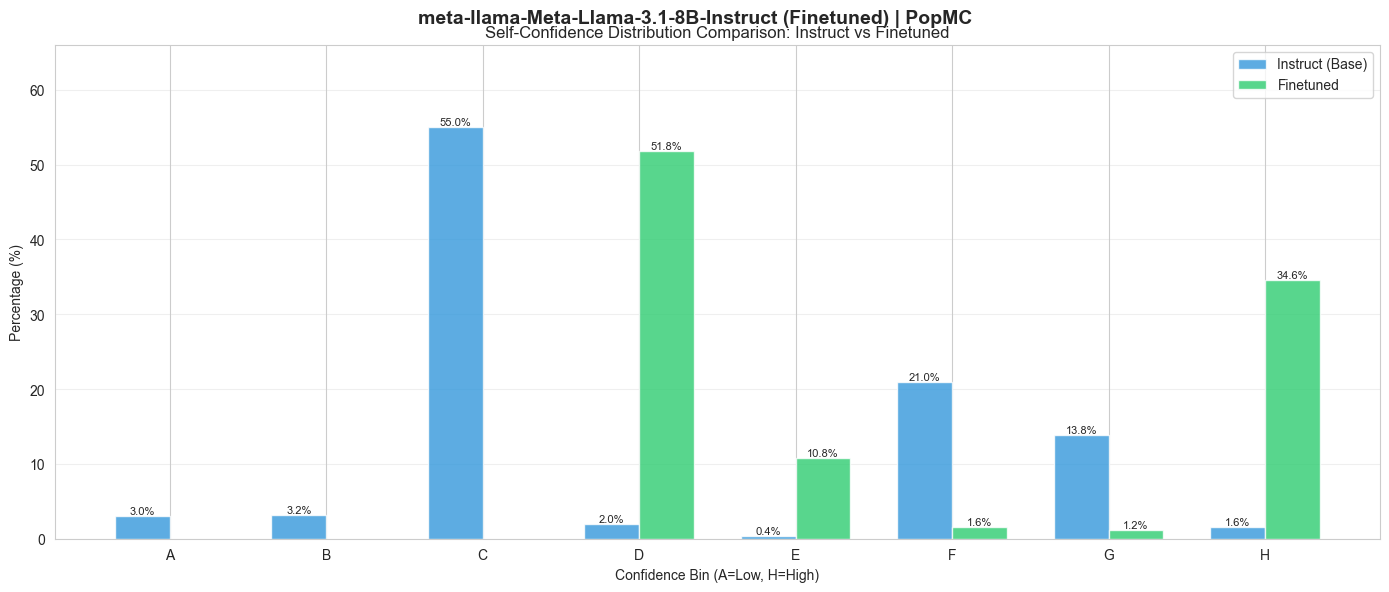

In [4]:
# 3. Self-Confidence Distribution Comparison
conf_bins = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']

if instruct_summary and finetuned_summary:
    instruct_conf = instruct_summary.get('predicted_confidence_distribution_pct', {})
    finetuned_conf = finetuned_summary.get('predicted_confidence_distribution_pct', {})
    
    instruct_conf_vals = [instruct_conf.get(bin, 0) for bin in conf_bins]
    finetuned_conf_vals = [finetuned_conf.get(bin, 0) for bin in conf_bins]
    
    fig, ax = plt.subplots(figsize=(14, 6))
    x = range(len(conf_bins))
    width = 0.35
    
    ax.bar([i - width/2 for i in x], instruct_conf_vals, width, label='Instruct (Base)', color='#3498db', alpha=0.8)
    ax.bar([i + width/2 for i in x], finetuned_conf_vals, width, label='Finetuned', color='#2ecc71', alpha=0.8)
    
    ax.set_xlabel('Confidence Bin (A=Low, H=High)')
    ax.set_ylabel('Percentage (%)')
    ax.set_title('Self-Confidence Distribution Comparison: Instruct vs Finetuned')
    ax.set_xticks(x)
    ax.set_xticklabels(conf_bins)
    ax.legend()
    ax.set_ylim(0, max(max(instruct_conf_vals), max(finetuned_conf_vals)) * 1.2)
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels for non-zero values
    for i, (inst_val, fin_val) in enumerate(zip(instruct_conf_vals, finetuned_conf_vals)):
        if inst_val > 0:
            ax.text(i - width/2, inst_val, f'{inst_val:.1f}%', ha='center', va='bottom', fontsize=8)
        if fin_val > 0:
            ax.text(i + width/2, fin_val, f'{fin_val:.1f}%', ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    add_model_dataset_info(fig, model_display, dataset_display, lora_name)
    plt.show()
else:
    # Single model view (backward compatibility)
    summary = finetuned_summary or instruct_summary
    conf_dist = summary.get('predicted_confidence_distribution_pct', {})
    conf_values = [conf_dist.get(bin, 0) for bin in conf_bins]
    
    fig, ax = plt.subplots(figsize=(12, 6))
    bars = ax.bar(conf_bins, conf_values, color=plt.cm.viridis([i/len(conf_bins) for i in range(len(conf_bins))]))
    ax.set_xlabel('Confidence Bin (A=Low, H=High)')
    ax.set_ylabel('Percentage (%)')
    ax.set_title('Self-Confidence Distribution (A-H)')
    ax.set_ylim(0, max(conf_values) * 1.2)
    ax.grid(axis='y', alpha=0.3)
    
    for bar, val in zip(bars, conf_values):
        if val > 0:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{val:.1f}%', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    add_model_dataset_info(fig, model_display, dataset_display, lora_name)
    plt.show()


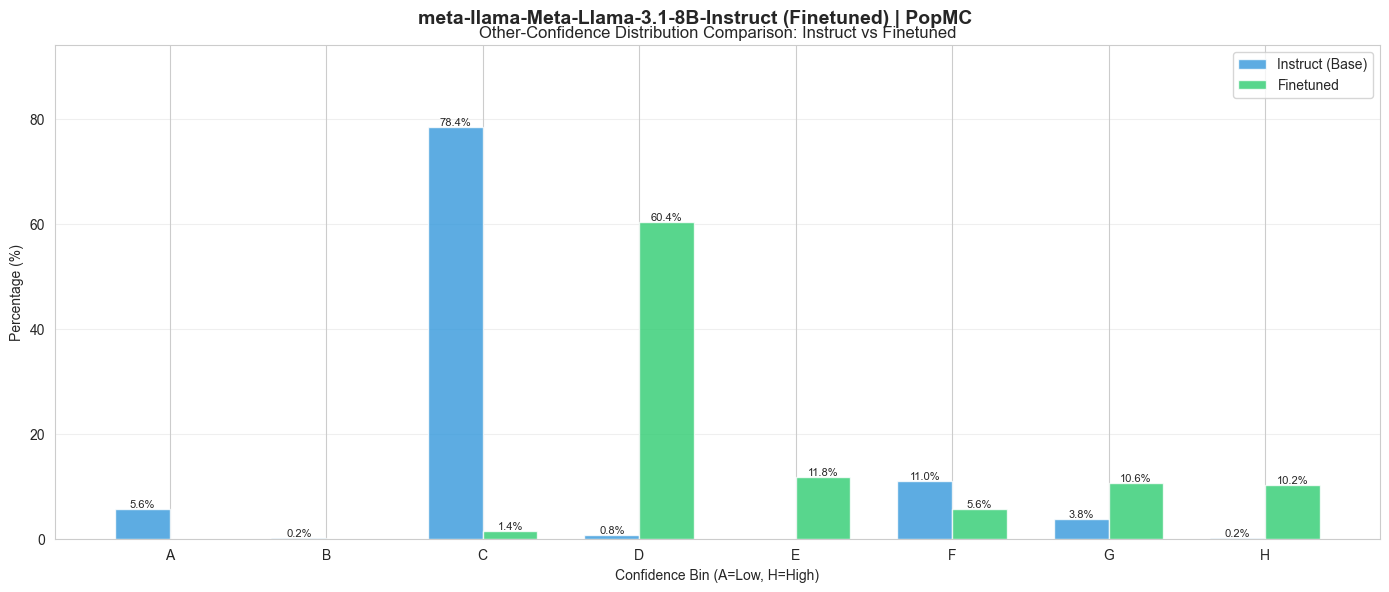

In [5]:
# 4. Other-Confidence Distribution Comparison
if instruct_summary and finetuned_summary:
    instruct_other_conf = instruct_summary.get('predicted_other_confidence_distribution_pct', {})
    finetuned_other_conf = finetuned_summary.get('predicted_other_confidence_distribution_pct', {})
    
    instruct_other_vals = [instruct_other_conf.get(bin, 0) for bin in conf_bins]
    finetuned_other_vals = [finetuned_other_conf.get(bin, 0) for bin in conf_bins]
    
    fig, ax = plt.subplots(figsize=(14, 6))
    x = range(len(conf_bins))
    width = 0.35
    
    ax.bar([i - width/2 for i in x], instruct_other_vals, width, label='Instruct (Base)', color='#3498db', alpha=0.8)
    ax.bar([i + width/2 for i in x], finetuned_other_vals, width, label='Finetuned', color='#2ecc71', alpha=0.8)
    
    ax.set_xlabel('Confidence Bin (A=Low, H=High)')
    ax.set_ylabel('Percentage (%)')
    ax.set_title('Other-Confidence Distribution Comparison: Instruct vs Finetuned')
    ax.set_xticks(x)
    ax.set_xticklabels(conf_bins)
    ax.legend()
    ax.set_ylim(0, max(max(instruct_other_vals), max(finetuned_other_vals)) * 1.2)
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels for non-zero values
    for i, (inst_val, fin_val) in enumerate(zip(instruct_other_vals, finetuned_other_vals)):
        if inst_val > 0:
            ax.text(i - width/2, inst_val, f'{inst_val:.1f}%', ha='center', va='bottom', fontsize=8)
        if fin_val > 0:
            ax.text(i + width/2, fin_val, f'{fin_val:.1f}%', ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    add_model_dataset_info(fig, model_display, dataset_display, lora_name)
    plt.show()
else:
    # Single model view (backward compatibility)
    summary = finetuned_summary or instruct_summary
    other_conf_dist = summary.get('predicted_other_confidence_distribution_pct', {})
    other_conf_values = [other_conf_dist.get(bin, 0) for bin in conf_bins]
    
    fig, ax = plt.subplots(figsize=(12, 6))
    bars = ax.bar(conf_bins, other_conf_values, color=plt.cm.plasma([i/len(conf_bins) for i in range(len(conf_bins))]))
    ax.set_xlabel('Confidence Bin (A=Low, H=High)')
    ax.set_ylabel('Percentage (%)')
    ax.set_title('Other-Confidence Distribution (A-H)')
    ax.set_ylim(0, max(other_conf_values) * 1.2)
    ax.grid(axis='y', alpha=0.3)
    
    for bar, val in zip(bars, other_conf_values):
        if val > 0:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{val:.1f}%', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    add_model_dataset_info(fig, model_display, dataset_display, lora_name)
    plt.show()


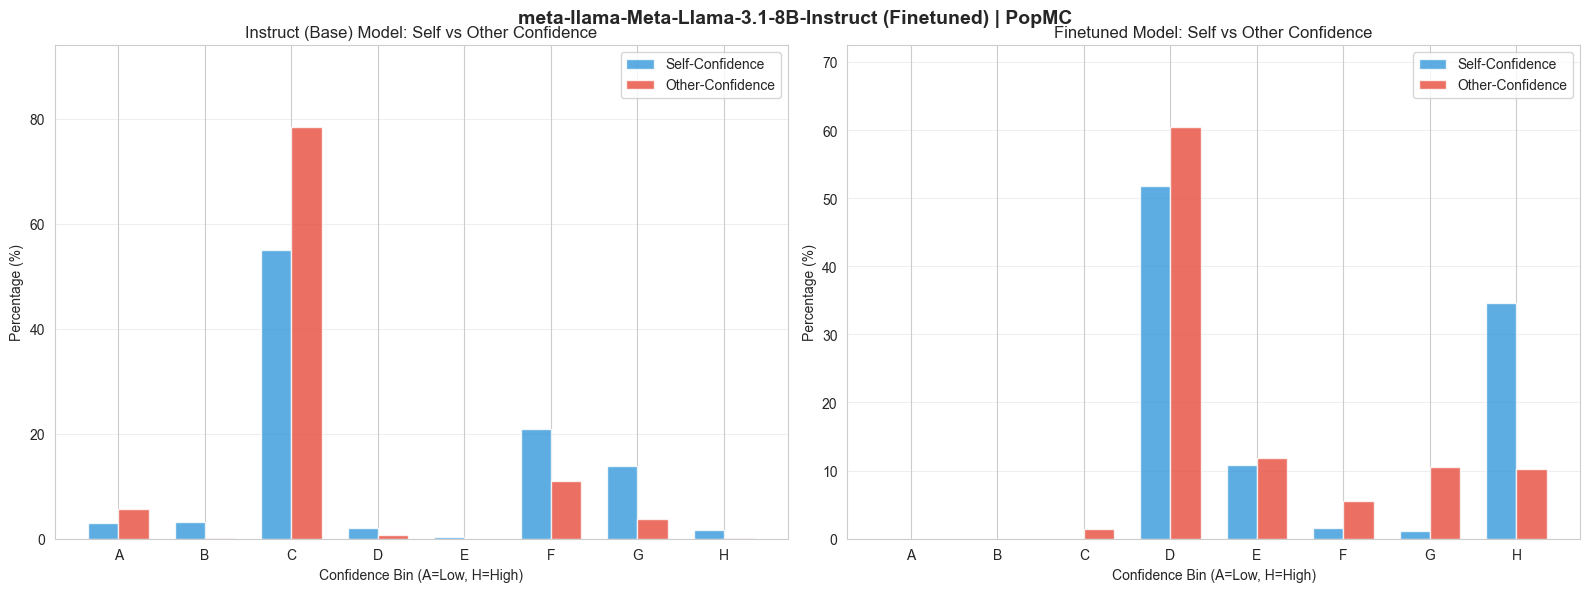

In [6]:
# 5. Self vs Other Confidence Comparison (Side-by-Side)
conf_bins = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']

if instruct_summary and finetuned_summary:
    # Create side-by-side comparison
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    x = range(len(conf_bins))
    width = 0.35
    
    # Left: Instruct model
    instruct_conf = instruct_summary.get('predicted_confidence_distribution_pct', {})
    instruct_other_conf = instruct_summary.get('predicted_other_confidence_distribution_pct', {})
    instruct_conf_vals = [instruct_conf.get(bin, 0) for bin in conf_bins]
    instruct_other_vals = [instruct_other_conf.get(bin, 0) for bin in conf_bins]
    
    ax1 = axes[0]
    ax1.bar([i - width/2 for i in x], instruct_conf_vals, width, label='Self-Confidence', color='#3498db', alpha=0.8)
    ax1.bar([i + width/2 for i in x], instruct_other_vals, width, label='Other-Confidence', color='#e74c3c', alpha=0.8)
    ax1.set_xlabel('Confidence Bin (A=Low, H=High)')
    ax1.set_ylabel('Percentage (%)')
    ax1.set_title('Instruct (Base) Model: Self vs Other Confidence')
    ax1.set_xticks(x)
    ax1.set_xticklabels(conf_bins)
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    ax1.set_ylim(0, max(max(instruct_conf_vals), max(instruct_other_vals)) * 1.2)
    
    # Right: Finetuned model
    finetuned_conf = finetuned_summary.get('predicted_confidence_distribution_pct', {})
    finetuned_other_conf = finetuned_summary.get('predicted_other_confidence_distribution_pct', {})
    finetuned_conf_vals = [finetuned_conf.get(bin, 0) for bin in conf_bins]
    finetuned_other_vals = [finetuned_other_conf.get(bin, 0) for bin in conf_bins]
    
    ax2 = axes[1]
    ax2.bar([i - width/2 for i in x], finetuned_conf_vals, width, label='Self-Confidence', color='#3498db', alpha=0.8)
    ax2.bar([i + width/2 for i in x], finetuned_other_vals, width, label='Other-Confidence', color='#e74c3c', alpha=0.8)
    ax2.set_xlabel('Confidence Bin (A=Low, H=High)')
    ax2.set_ylabel('Percentage (%)')
    ax2.set_title('Finetuned Model: Self vs Other Confidence')
    ax2.set_xticks(x)
    ax2.set_xticklabels(conf_bins)
    ax2.legend()
    ax2.grid(axis='y', alpha=0.3)
    ax2.set_ylim(0, max(max(finetuned_conf_vals), max(finetuned_other_vals)) * 1.2)
    
    plt.tight_layout()
    add_model_dataset_info(fig, model_display, dataset_display, lora_name)
    plt.show()
elif finetuned_summary:
    # Single model view (backward compatibility)
    finetuned_conf = finetuned_summary.get('predicted_confidence_distribution_pct', {})
    finetuned_other_conf = finetuned_summary.get('predicted_other_confidence_distribution_pct', {})
    finetuned_conf_vals = [finetuned_conf.get(bin, 0) for bin in conf_bins]
    finetuned_other_vals = [finetuned_other_conf.get(bin, 0) for bin in conf_bins]
    
    fig, ax = plt.subplots(figsize=(14, 6))
    x = range(len(conf_bins))
    width = 0.35
    
    ax.bar([i - width/2 for i in x], finetuned_conf_vals, width, label='Self-Confidence', color='#3498db', alpha=0.8)
    ax.bar([i + width/2 for i in x], finetuned_other_vals, width, label='Other-Confidence', color='#e74c3c', alpha=0.8)
    ax.set_xlabel('Confidence Bin (A=Low, H=High)')
    ax.set_ylabel('Percentage (%)')
    ax.set_title('Finetuned Model: Self vs Other Confidence Distribution')
    ax.set_xticks(x)
    ax.set_xticklabels(conf_bins)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    add_model_dataset_info(fig, model_display, dataset_display, lora_name)
    plt.show()


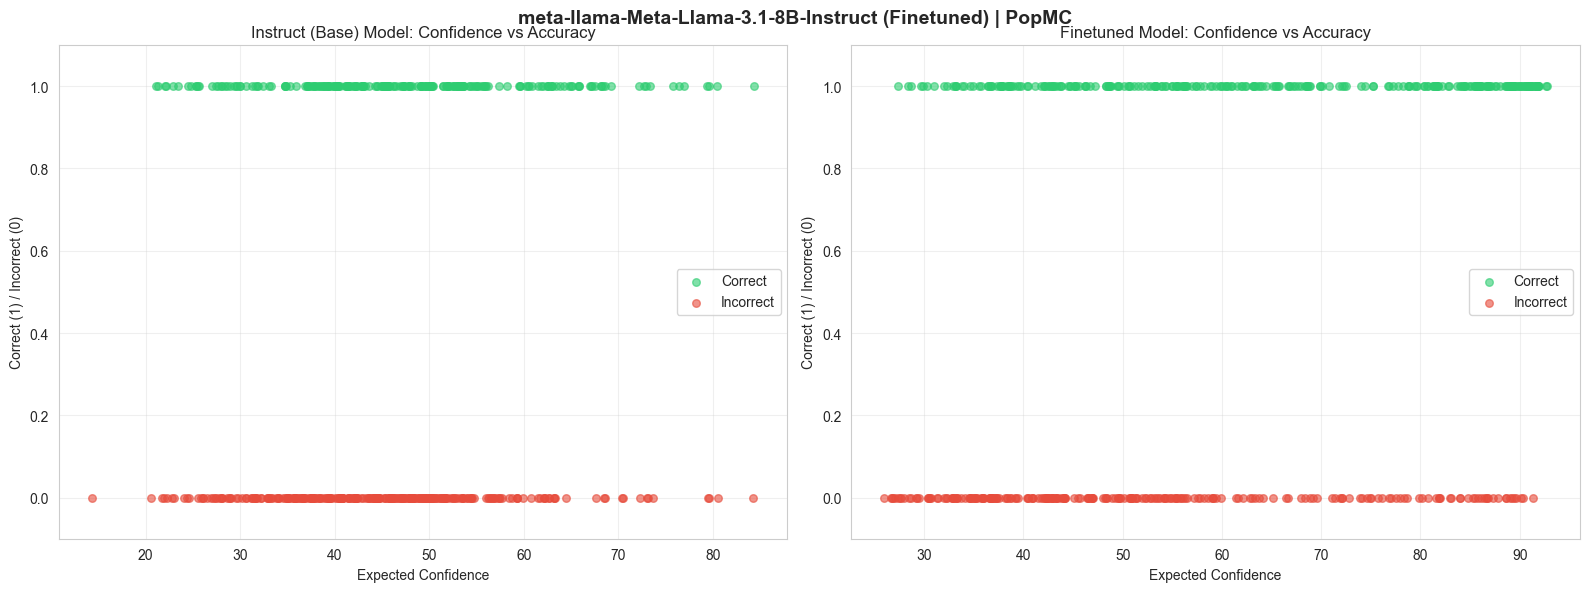

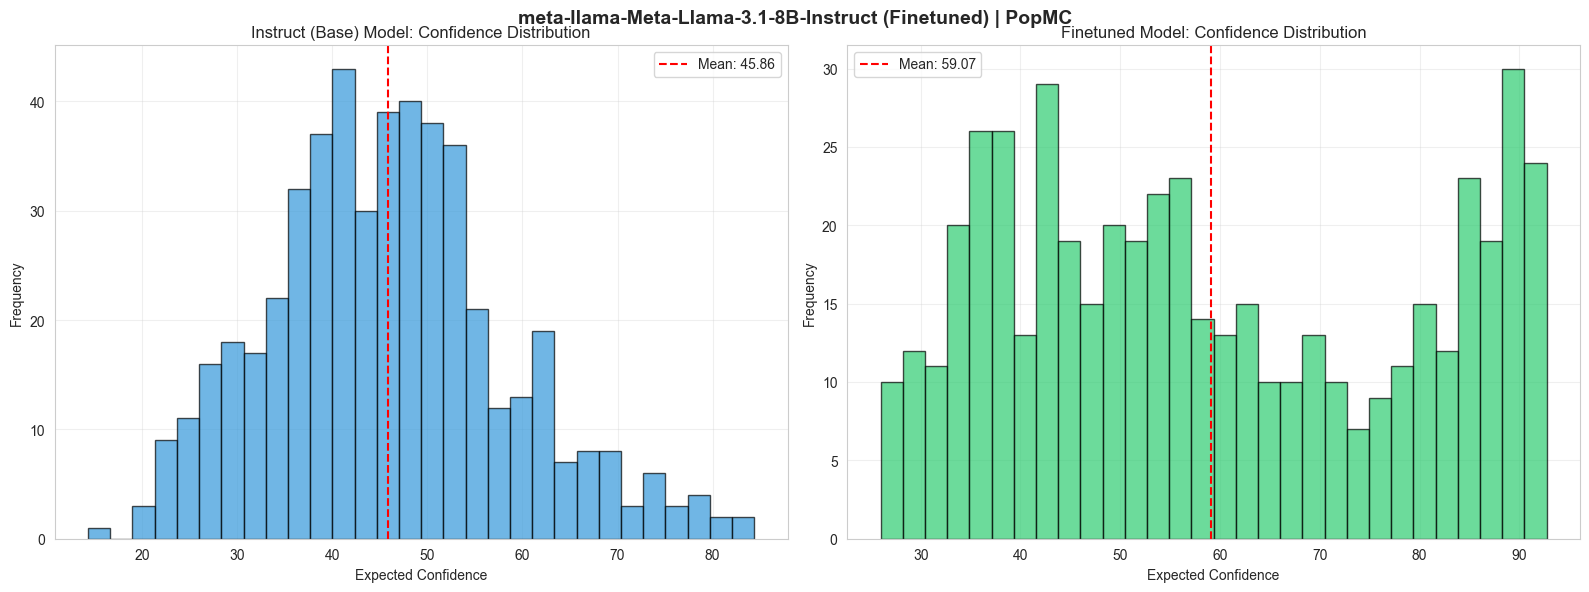

In [7]:
# 6. Confidence vs Accuracy Scatter Comparison
if len(instruct_samples) > 0 and len(finetuned_samples) > 0:
    # Create DataFrames for easier analysis
    instruct_df = pd.DataFrame(instruct_samples)
    finetuned_df = pd.DataFrame(finetuned_samples)
    
    # Match samples by qid for comparison
    instruct_df['is_correct'] = instruct_df['model_answer'] == instruct_df['correct_answer']
    finetuned_df['is_correct'] = finetuned_df['model_answer'] == finetuned_df['correct_answer']
    
    # Merge on qid
    merged = instruct_df[['qid', 'expected_confidence', 'is_correct']].merge(
        finetuned_df[['qid', 'expected_confidence', 'is_correct']], 
        on='qid', 
        suffixes=('_instruct', '_finetuned')
    )
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Left: Instruct model
    ax1 = axes[0]
    correct = merged['is_correct_instruct']
    conf = merged['expected_confidence_instruct']
    ax1.scatter(conf[correct], [1]*correct.sum(), alpha=0.6, color='#2ecc71', label='Correct', s=30)
    ax1.scatter(conf[~correct], [0]*(~correct).sum(), alpha=0.6, color='#e74c3c', label='Incorrect', s=30)
    ax1.set_xlabel('Expected Confidence')
    ax1.set_ylabel('Correct (1) / Incorrect (0)')
    ax1.set_title('Instruct (Base) Model: Confidence vs Accuracy')
    ax1.legend()
    ax1.grid(alpha=0.3)
    ax1.set_ylim(-0.1, 1.1)
    
    # Right: Finetuned model
    ax2 = axes[1]
    correct = merged['is_correct_finetuned']
    conf = merged['expected_confidence_finetuned']
    ax2.scatter(conf[correct], [1]*correct.sum(), alpha=0.6, color='#2ecc71', label='Correct', s=30)
    ax2.scatter(conf[~correct], [0]*(~correct).sum(), alpha=0.6, color='#e74c3c', label='Incorrect', s=30)
    ax2.set_xlabel('Expected Confidence')
    ax2.set_ylabel('Correct (1) / Incorrect (0)')
    ax2.set_title('Finetuned Model: Confidence vs Accuracy')
    ax2.legend()
    ax2.grid(alpha=0.3)
    ax2.set_ylim(-0.1, 1.1)
    
    plt.tight_layout()
    add_model_dataset_info(fig, model_display, dataset_display, lora_name)
    plt.show()
    
    # Also show side-by-side confidence distributions
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    ax1 = axes[0]
    ax1.hist(instruct_df['expected_confidence'], bins=30, alpha=0.7, color='#3498db', edgecolor='black')
    ax1.set_xlabel('Expected Confidence')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Instruct (Base) Model: Confidence Distribution')
    ax1.axvline(instruct_df['expected_confidence'].mean(), color='red', linestyle='--', 
                label=f'Mean: {instruct_df["expected_confidence"].mean():.2f}')
    ax1.legend()
    ax1.grid(alpha=0.3)
    
    ax2 = axes[1]
    ax2.hist(finetuned_df['expected_confidence'], bins=30, alpha=0.7, color='#2ecc71', edgecolor='black')
    ax2.set_xlabel('Expected Confidence')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Finetuned Model: Confidence Distribution')
    ax2.axvline(finetuned_df['expected_confidence'].mean(), color='red', linestyle='--',
                label=f'Mean: {finetuned_df["expected_confidence"].mean():.2f}')
    ax2.legend()
    ax2.grid(alpha=0.3)
    
    plt.tight_layout()
    add_model_dataset_info(fig, model_display, dataset_display, lora_name)
    plt.show()


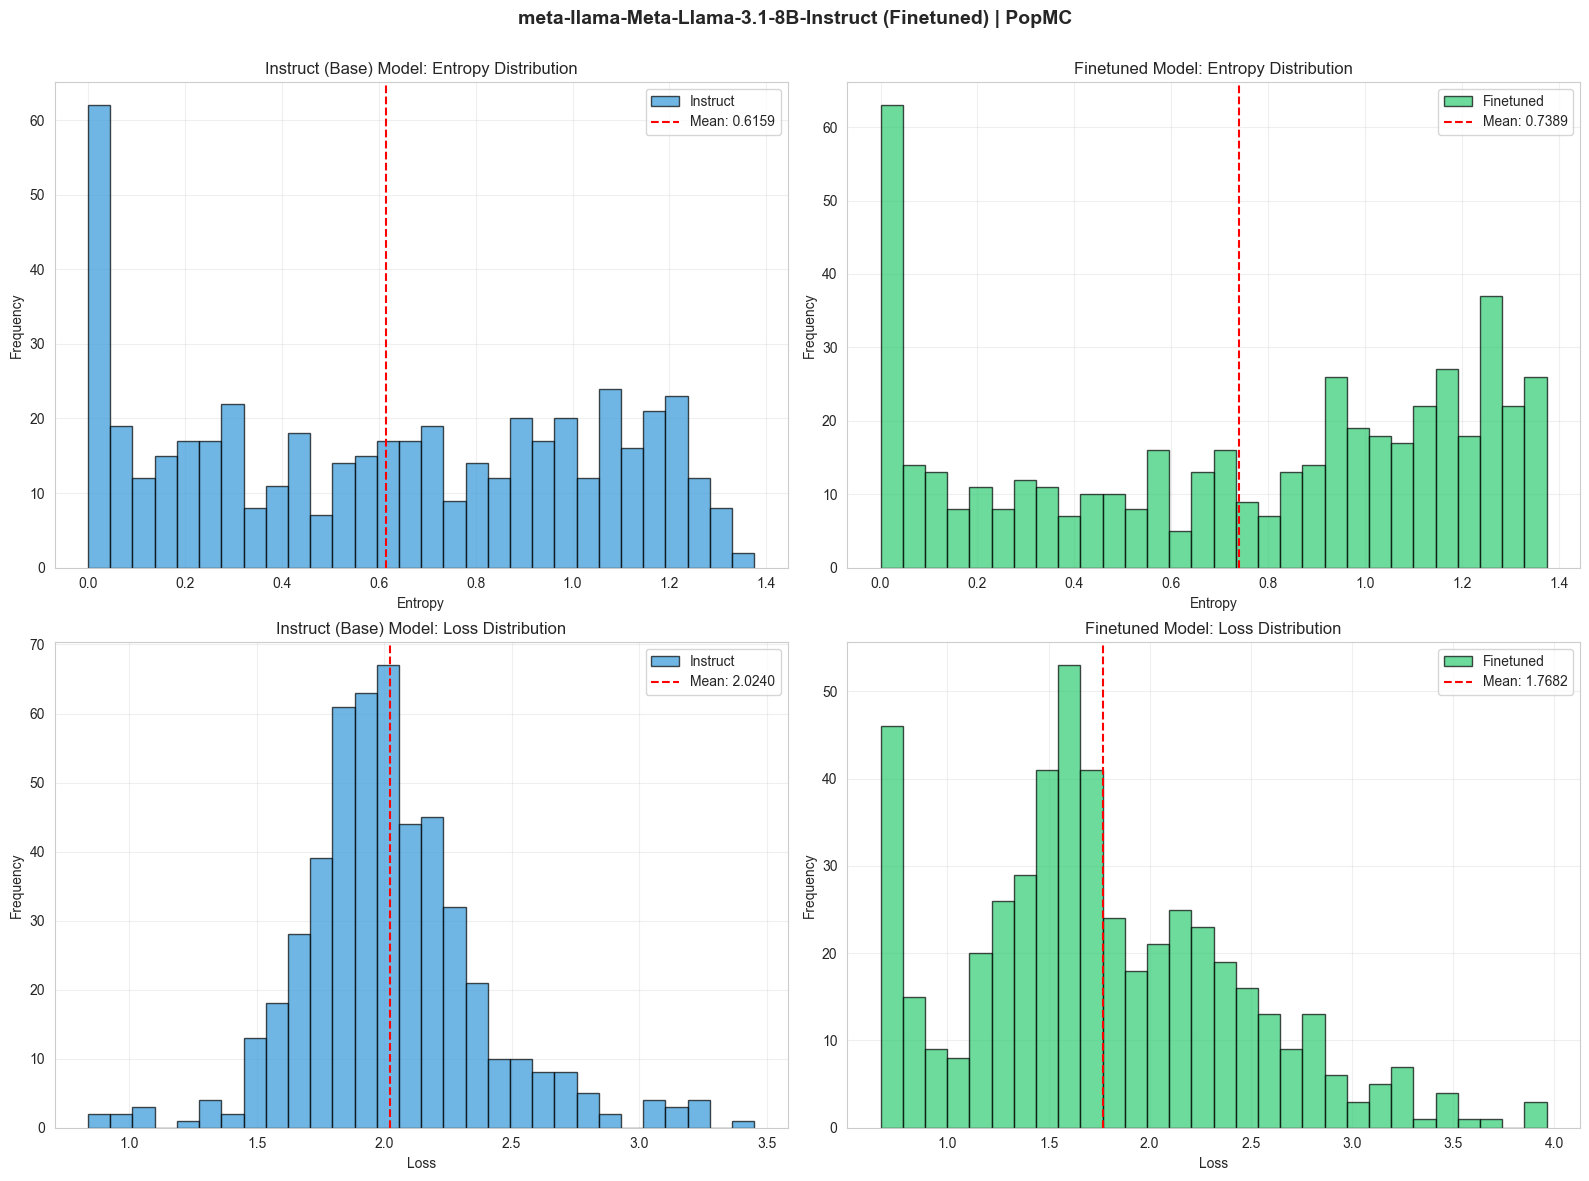

In [8]:
# 7. Entropy and Loss Distributions Comparison
if len(instruct_samples) > 0 and len(finetuned_samples) > 0:
    instruct_df = pd.DataFrame(instruct_samples)
    finetuned_df = pd.DataFrame(finetuned_samples)
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Top row: Entropy distributions
    ax1 = axes[0, 0]
    ax1.hist(instruct_df['entropy'], bins=30, alpha=0.7, color='#3498db', edgecolor='black', label='Instruct')
    ax1.axvline(instruct_df['entropy'].mean(), color='red', linestyle='--', 
                label=f'Mean: {instruct_df["entropy"].mean():.4f}')
    ax1.set_xlabel('Entropy')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Instruct (Base) Model: Entropy Distribution')
    ax1.legend()
    ax1.grid(alpha=0.3)
    
    ax2 = axes[0, 1]
    ax2.hist(finetuned_df['entropy'], bins=30, alpha=0.7, color='#2ecc71', edgecolor='black', label='Finetuned')
    ax2.axvline(finetuned_df['entropy'].mean(), color='red', linestyle='--',
                label=f'Mean: {finetuned_df["entropy"].mean():.4f}')
    ax2.set_xlabel('Entropy')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Finetuned Model: Entropy Distribution')
    ax2.legend()
    ax2.grid(alpha=0.3)
    
    # Bottom row: Loss distributions
    ax3 = axes[1, 0]
    ax3.hist(instruct_df['loss'], bins=30, alpha=0.7, color='#3498db', edgecolor='black', label='Instruct')
    ax3.axvline(instruct_df['loss'].mean(), color='red', linestyle='--',
                label=f'Mean: {instruct_df["loss"].mean():.4f}')
    ax3.set_xlabel('Loss')
    ax3.set_ylabel('Frequency')
    ax3.set_title('Instruct (Base) Model: Loss Distribution')
    ax3.legend()
    ax3.grid(alpha=0.3)
    
    ax4 = axes[1, 1]
    ax4.hist(finetuned_df['loss'], bins=30, alpha=0.7, color='#2ecc71', edgecolor='black', label='Finetuned')
    ax4.axvline(finetuned_df['loss'].mean(), color='red', linestyle='--',
                label=f'Mean: {finetuned_df["loss"].mean():.4f}')
    ax4.set_xlabel('Loss')
    ax4.set_ylabel('Frequency')
    ax4.set_title('Finetuned Model: Loss Distribution')
    ax4.legend()
    ax4.grid(alpha=0.3)
    
    plt.tight_layout()
    add_model_dataset_info(fig, model_display, dataset_display, lora_name)
    plt.show()


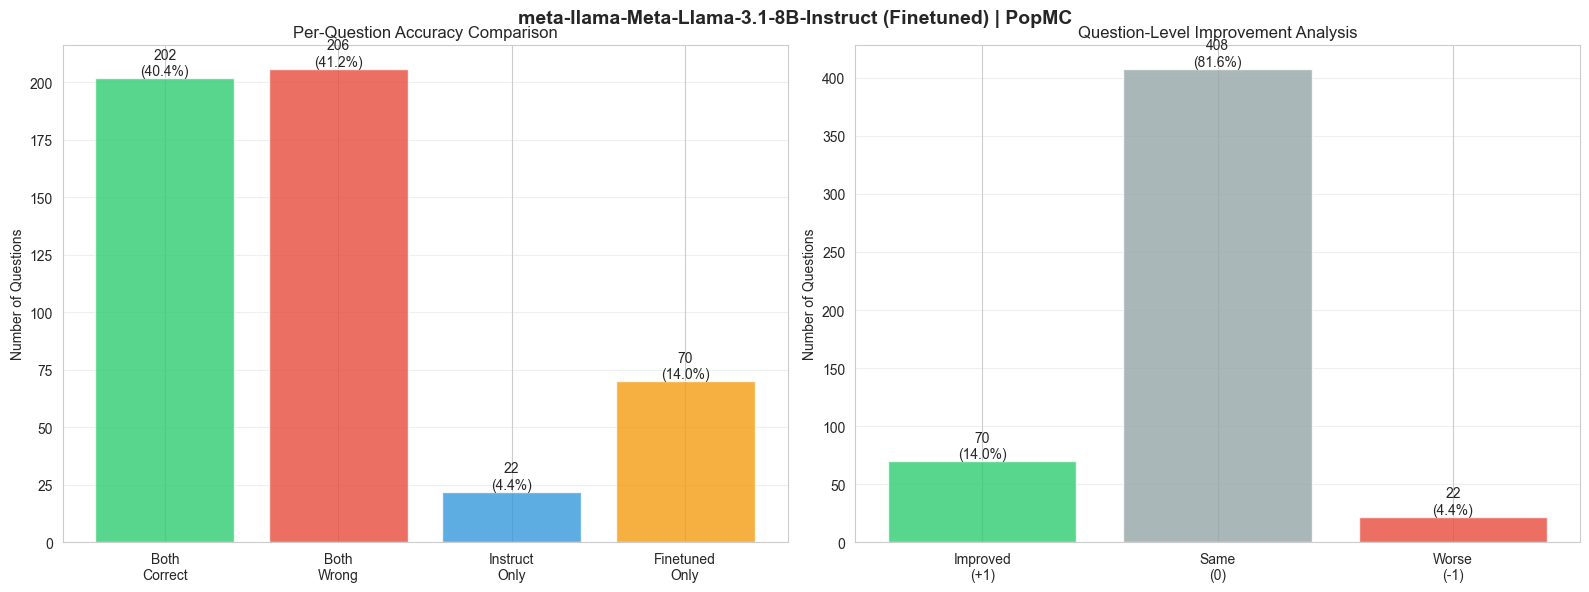


📊 Per-Question Analysis:
   Total questions: 500
   Both correct: 202 (40.4%)
   Both wrong: 206 (41.2%)
   Improved (wrong→correct): 70 (14.0%)
   Regressed (correct→wrong): 22 (4.4%)
   Net improvement: 48 questions


In [9]:
# 8. Per-Question Accuracy Comparison
if len(instruct_samples) > 0 and len(finetuned_samples) > 0:
    instruct_df = pd.DataFrame(instruct_samples)
    finetuned_df = pd.DataFrame(finetuned_samples)
    
    # Match samples by qid
    merged = instruct_df[['qid', 'model_answer', 'correct_answer']].merge(
        finetuned_df[['qid', 'model_answer', 'correct_answer']], 
        on='qid', 
        suffixes=('_instruct', '_finetuned')
    )
    
    merged['correct_instruct'] = merged['model_answer_instruct'] == merged['correct_answer_instruct']
    merged['correct_finetuned'] = merged['model_answer_finetuned'] == merged['correct_answer_finetuned']
    
    # Categorize questions
    both_correct = (merged['correct_instruct'] & merged['correct_finetuned']).sum()
    both_wrong = ((~merged['correct_instruct']) & (~merged['correct_finetuned'])).sum()
    instruct_only = (merged['correct_instruct'] & (~merged['correct_finetuned'])).sum()
    finetuned_only = ((~merged['correct_instruct']) & merged['correct_finetuned']).sum()
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Left: Question outcome categories
    ax1 = axes[0]
    categories = ['Both\nCorrect', 'Both\nWrong', 'Instruct\nOnly', 'Finetuned\nOnly']
    counts = [both_correct, both_wrong, instruct_only, finetuned_only]
    colors = ['#2ecc71', '#e74c3c', '#3498db', '#f39c12']
    bars = ax1.bar(categories, counts, color=colors, alpha=0.8)
    ax1.set_ylabel('Number of Questions')
    ax1.set_title('Per-Question Accuracy Comparison')
    ax1.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{count}\n({count/len(merged)*100:.1f}%)',
                ha='center', va='bottom', fontsize=10)
    
    # Right: Improvement breakdown
    ax2 = axes[1]
    improvement_categories = ['Improved\n(+1)', 'Same\n(0)', 'Worse\n(-1)']
    improvement_counts = [
        finetuned_only,  # Improved: wrong -> correct
        both_correct + both_wrong,  # Same: both correct or both wrong
        instruct_only  # Worse: correct -> wrong
    ]
    improvement_colors = ['#2ecc71', '#95a5a6', '#e74c3c']
    bars2 = ax2.bar(improvement_categories, improvement_counts, color=improvement_colors, alpha=0.8)
    ax2.set_ylabel('Number of Questions')
    ax2.set_title('Question-Level Improvement Analysis')
    ax2.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for bar, count in zip(bars2, improvement_counts):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{count}\n({count/len(merged)*100:.1f}%)',
                ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    add_model_dataset_info(fig, model_display, dataset_display, lora_name)
    plt.show()
    
    print(f"\n📊 Per-Question Analysis:")
    print(f"   Total questions: {len(merged)}")
    print(f"   Both correct: {both_correct} ({both_correct/len(merged)*100:.1f}%)")
    print(f"   Both wrong: {both_wrong} ({both_wrong/len(merged)*100:.1f}%)")
    print(f"   Improved (wrong→correct): {finetuned_only} ({finetuned_only/len(merged)*100:.1f}%)")
    print(f"   Regressed (correct→wrong): {instruct_only} ({instruct_only/len(merged)*100:.1f}%)")
    print(f"   Net improvement: {finetuned_only - instruct_only} questions")


/var/folders/43/_0d5jq894wvgs7d31w0ccq980000gn/T/ipykernel_65241/2222953734.py:497: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax4.set_xticklabels(mse_names, fontsize=9)


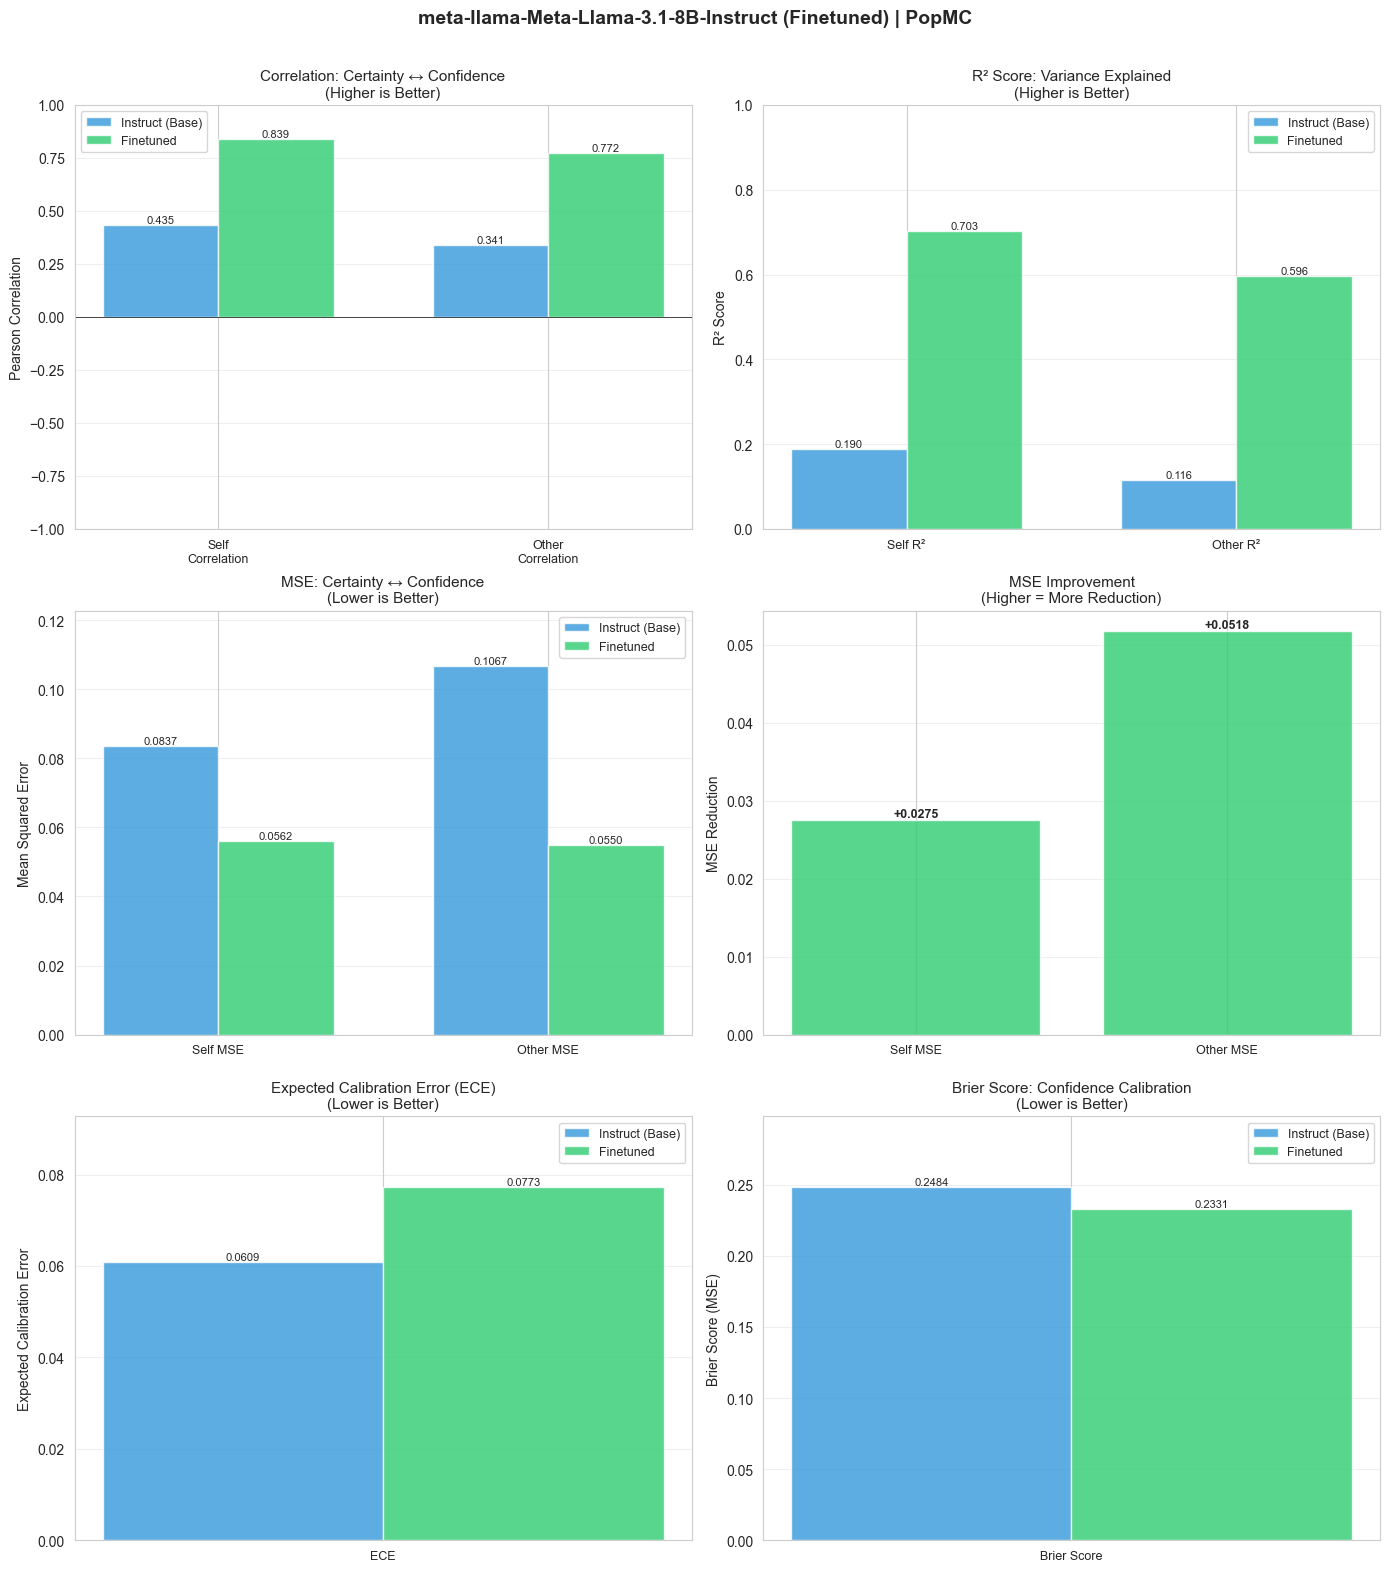


CALIBRATION METRICS COMPARISON

1. CORRELATION (Certainty ↔ Confidence) - Higher is Better:
   Self-Correlation:
     Instruct (Base): 0.4355
     Finetuned:       0.8386
     Improvement:     +0.4031
   Other-Correlation:
     Instruct (Base): 0.3413
     Finetuned:       0.7718
     Improvement:     +0.4305

2. R² SCORE (Variance Explained) - Higher is Better:
   Self R²:
     Instruct (Base): 0.1896
     Finetuned:       0.7032
     Improvement:     +0.5135
   Other R²:
     Instruct (Base): 0.1165
     Finetuned:       0.5956
     Improvement:     +0.4791

3. MSE (Certainty ↔ Confidence) - Lower is Better:
   Self MSE:
     Instruct (Base): 0.083705
     Finetuned:       0.056163
     Reduction:       +0.027542
   Other MSE:
     Instruct (Base): 0.106745
     Finetuned:       0.054970
     Reduction:       +0.051775

4. EXPECTED CALIBRATION ERROR (ECE) - Lower is Better:
     Instruct (Base): 0.060923
     Finetuned:       0.077288
     Reduction:       -0.016366

5. BRIER SCORE 

In [10]:
# # 11. MSE Metrics Comparison (Self-Live and Other-Live MSE)
# # Compute MSE from sample data
# from sklearn.metrics import mean_squared_error

# if len(instruct_samples) > 0 and len(finetuned_samples) > 0:
#     # Extract data for instruct model
#     instruct_entropy = np.array([s.get('entropy', 0) for s in instruct_samples])
#     instruct_conf = np.array([s.get('expected_confidence', 0) for s in instruct_samples])
#     instruct_other_conf = np.array([s.get('expected_other_confidence', 0) for s in instruct_samples])
#     instruct_correct = np.array([1.0 if s.get('model_answer') == s.get('correct_answer') else 0.0 for s in instruct_samples])
    
#     # Extract data for finetuned model
#     finetuned_entropy = np.array([s.get('entropy', 0) for s in finetuned_samples])
#     finetuned_conf = np.array([s.get('expected_confidence', 0) for s in finetuned_samples])
#     finetuned_other_conf = np.array([s.get('expected_other_confidence', 0) for s in finetuned_samples])
#     finetuned_correct = np.array([1.0 if s.get('model_answer') == s.get('correct_answer') else 0.0 for s in finetuned_samples])
    
#     # Normalize entropy and confidence to 0-1 range for MSE computation
#     # For entropy: normalize by max entropy (log(4) for 4 choices, but use actual max)
#     max_entropy = max(np.max(instruct_entropy), np.max(finetuned_entropy)) if len(instruct_entropy) > 0 and len(finetuned_entropy) > 0 else 1.0
#     if max_entropy > 0:
#         instruct_entropy_norm = instruct_entropy / max_entropy
#         finetuned_entropy_norm = finetuned_entropy / max_entropy
#     else:
#         instruct_entropy_norm = instruct_entropy
#         finetuned_entropy_norm = finetuned_entropy
    
#     # For confidence: normalize to 0-1 (assuming confidence is 0-100 scale)
#     instruct_conf_norm = instruct_conf / 100.0
#     finetuned_conf_norm = finetuned_conf / 100.0
#     instruct_other_conf_norm = instruct_other_conf / 100.0
#     finetuned_other_conf_norm = finetuned_other_conf / 100.0
    
#     # Compute self_live_mse: MSE between normalized entropy and normalized self-confidence
#     try:
#         if len(instruct_entropy_norm) > 0:
#             instruct_self_live_mse = mean_squared_error(instruct_entropy_norm, instruct_conf_norm)
#         else:
#             instruct_self_live_mse = 0.0
#     except:
#         instruct_self_live_mse = 0.0
    
#     try:
#         if len(finetuned_entropy_norm) > 0:
#             finetuned_self_live_mse = mean_squared_error(finetuned_entropy_norm, finetuned_conf_norm)
#         else:
#             finetuned_self_live_mse = 0.0
#     except:
#         finetuned_self_live_mse = 0.0
    
#     # Compute other_live_mse: MSE between normalized entropy and normalized other-confidence
#     try:
#         if len(instruct_entropy_norm) > 0:
#             instruct_other_live_mse = mean_squared_error(instruct_entropy_norm, instruct_other_conf_norm)
#         else:
#             instruct_other_live_mse = 0.0
#     except:
#         instruct_other_live_mse = 0.0
    
#     try:
#         if len(finetuned_entropy_norm) > 0:
#             finetuned_other_live_mse = mean_squared_error(finetuned_entropy_norm, finetuned_other_conf_norm)
#         else:
#             finetuned_other_live_mse = 0.0
#     except:
#         finetuned_other_live_mse = 0.0
    
#     # Compute calibration_mse: Brier score (MSE between confidence and correctness)
#     try:
#         if len(instruct_conf_norm) > 0:
#             instruct_calibration_mse = mean_squared_error(instruct_correct, instruct_conf_norm)
#         else:
#             instruct_calibration_mse = 0.0
#     except:
#         instruct_calibration_mse = 0.0
    
#     try:
#         if len(finetuned_conf_norm) > 0:
#             finetuned_calibration_mse = mean_squared_error(finetuned_correct, finetuned_conf_norm)
#         else:
#             finetuned_calibration_mse = 0.0
#     except:
#         finetuned_calibration_mse = 0.0
    
#     # Create side-by-side comparison
#     fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
#     mse_names = ['Self-Live\nMSE', 'Other-Live\nMSE', 'Calibration\nMSE (Brier)']
#     x = range(len(mse_names))
#     width = 0.35
    
#     instruct_mses = [instruct_self_live_mse, instruct_other_live_mse, instruct_calibration_mse]
#     finetuned_mses = [finetuned_self_live_mse, finetuned_other_live_mse, finetuned_calibration_mse]
    
#     # Left: Bar chart comparison
#     ax1 = axes[0]
#     bars1 = ax1.bar([i - width/2 for i in x], instruct_mses, width, label='Instruct (Base)', color='#3498db', alpha=0.8)
#     bars2 = ax1.bar([i + width/2 for i in x], finetuned_mses, width, label='Finetuned', color='#2ecc71', alpha=0.8)
#     ax1.set_ylabel('Mean Squared Error')
#     ax1.set_title('MSE Metrics: Instruct vs Finetuned')
#     ax1.set_xticks(x)
#     ax1.set_xticklabels(mse_names)
#     ax1.legend()
#     ax1.grid(axis='y', alpha=0.3)
#     ax1.set_ylim(0, max(max(instruct_mses), max(finetuned_mses)) * 1.2)
    
#     # Add value labels
#     for i, (inst_val, fin_val) in enumerate(zip(instruct_mses, finetuned_mses)):
#         ax1.text(i - width/2, inst_val, f'{inst_val:.4f}', ha='center', 
#                 va='bottom', fontsize=9)
#         ax1.text(i + width/2, fin_val, f'{fin_val:.4f}', ha='center',
#                 va='bottom', fontsize=9)
    
#     # Right: Improvement visualization (lower MSE is better, so improvement = reduction)
#     ax2 = axes[1]
#     improvements = [instruct_self_live_mse - finetuned_self_live_mse,
#                    instruct_other_live_mse - finetuned_other_live_mse,
#                    instruct_calibration_mse - finetuned_calibration_mse]
#     colors = ['#2ecc71' if imp >= 0 else '#e74c3c' for imp in improvements]
#     bars = ax2.bar(mse_names, improvements, color=colors, alpha=0.8)
#     ax2.set_ylabel('MSE Reduction (Instruct - Finetuned)')
#     ax2.set_title('MSE Improvement: Finetuned vs Instruct\n(Lower MSE is Better)')
#     ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
#     ax2.grid(axis='y', alpha=0.3)
    
#     # Set y-axis limits with some padding
#     if len(improvements) > 0:
#         y_min = min(improvements) * 1.2 if min(improvements) < 0 else min(improvements) * 0.8
#         y_max = max(improvements) * 1.2 if max(improvements) > 0 else max(improvements) * 0.8
#         ax2.set_ylim(y_min, y_max)
    
#     # Add value labels
#     for bar, imp in zip(bars, improvements):
#         height = bar.get_height()
#         ax2.text(bar.get_x() + bar.get_width()/2., height,
#                 f'{imp:+.4f}', ha='center',
#                 va='bottom' if imp >= 0 else 'top', fontsize=10, fontweight='bold')
    
#     plt.tight_layout()
#     add_model_dataset_info(fig, model_display, dataset_display, lora_name)
#     plt.show()
    
#     # Print detailed comparison
#     print("\n" + "="*80)
#     print("MSE METRICS COMPARISON")
#     print("="*80)
#     print(f"Self-Live MSE (Entropy ↔ Self-Confidence):")
#     print(f"  Instruct (Base): {instruct_self_live_mse:.6f}")
#     print(f"  Finetuned:       {finetuned_self_live_mse:.6f}")
#     print(f"  Reduction:       {instruct_self_live_mse - finetuned_self_live_mse:+.6f} (lower is better)")
#     print()
#     print(f"Other-Live MSE (Entropy ↔ Other-Confidence):")
#     print(f"  Instruct (Base): {instruct_other_live_mse:.6f}")
#     print(f"  Finetuned:       {finetuned_other_live_mse:.6f}")
#     print(f"  Reduction:       {instruct_other_live_mse - finetuned_other_live_mse:+.6f} (lower is better)")
#     print()
#     print(f"Calibration MSE / Brier Score (Confidence ↔ Correctness):")
#     print(f"  Instruct (Base): {instruct_calibration_mse:.6f}")
#     print(f"  Finetuned:       {finetuned_calibration_mse:.6f}")
#     print(f"  Reduction:       {instruct_calibration_mse - finetuned_calibration_mse:+.6f} (lower is better)")
#     print("="*80)
    
#     # Interpretation
#     print("\n📊 Interpretation:")
#     print("  • Self-Live MSE: Prediction error between normalized entropy and self-confidence.")
#     print("    Lower = better alignment between uncertainty and self-confidence predictions.")
#     print("  • Other-Live MSE: Prediction error between normalized entropy and other-confidence.")
#     print("    Lower = better alignment between uncertainty and other-confidence predictions.")
#     print("  • Calibration MSE (Brier Score): Prediction error between confidence and correctness.")
#     print("    Lower = better calibrated confidence (confidence matches actual accuracy).")
# elif len(finetuned_samples) > 0:
#     # Single model view (backward compatibility) - compute from samples
#     finetuned_entropy = np.array([s.get('entropy', 0) for s in finetuned_samples])
#     finetuned_conf = np.array([s.get('expected_confidence', 0) for s in finetuned_samples])
#     finetuned_other_conf = np.array([s.get('expected_other_confidence', 0) for s in finetuned_samples])
#     finetuned_correct = np.array([1.0 if s.get('model_answer') == s.get('correct_answer') else 0.0 for s in finetuned_samples])
    
#     # Normalize for MSE computation
#     max_entropy = np.max(finetuned_entropy) if len(finetuned_entropy) > 0 else 1.0
#     if max_entropy > 0:
#         finetuned_entropy_norm = finetuned_entropy / max_entropy
#     else:
#         finetuned_entropy_norm = finetuned_entropy
    
#     finetuned_conf_norm = finetuned_conf / 100.0
#     finetuned_other_conf_norm = finetuned_other_conf / 100.0
    
#     try:
#         if len(finetuned_entropy_norm) > 0:
#             finetuned_self_live_mse = mean_squared_error(finetuned_entropy_norm, finetuned_conf_norm)
#         else:
#             finetuned_self_live_mse = 0.0
#     except:
#         finetuned_self_live_mse = 0.0
    
#     try:
#         if len(finetuned_entropy_norm) > 0:
#             finetuned_other_live_mse = mean_squared_error(finetuned_entropy_norm, finetuned_other_conf_norm)
#         else:
#             finetuned_other_live_mse = 0.0
#     except:
#         finetuned_other_live_mse = 0.0
    
#     try:
#         if len(finetuned_conf_norm) > 0:
#             finetuned_calibration_mse = mean_squared_error(finetuned_correct, finetuned_conf_norm)
#         else:
#             finetuned_calibration_mse = 0.0
#     except:
#         finetuned_calibration_mse = 0.0
    
#     fig, ax = plt.subplots(figsize=(12, 6))
#     mse_names = ['Self-Live\nMSE', 'Other-Live\nMSE', 'Calibration\nMSE (Brier)']
#     mses = [finetuned_self_live_mse, finetuned_other_live_mse, finetuned_calibration_mse]
#     bars = ax.bar(mse_names, mses, color=['#3498db', '#2ecc71', '#9b59b6'], alpha=0.8)
#     ax.set_ylabel('Mean Squared Error')
#     ax.set_title('MSE Metrics')
#     ax.grid(axis='y', alpha=0.3)
#     ax.set_ylim(0, max(mses) * 1.2)
    
#     for bar, mse in zip(bars, mses):
#         height = bar.get_height()
#         ax.text(bar.get_x() + bar.get_width()/2., height,
#                 f'{mse:.4f}', ha='center',
#                 va='bottom', fontsize=10, fontweight='bold')
    
#     plt.tight_layout()
#     add_model_dataset_info(fig, model_display, dataset_display, lora_name)
#     plt.show()
    
#     print(f"\nMSE Metrics:")
#     print(f"  Self-Live MSE: {finetuned_self_live_mse:.6f}")
#     print(f"  Other-Live MSE: {finetuned_other_live_mse:.6f}")
#     print(f"  Calibration MSE (Brier Score): {finetuned_calibration_mse:.6f}")

# 11. Calibration Metrics Comparison (Correlation, R², MSE, ECE, Brier)
from sklearn.metrics import mean_squared_error, r2_score

def compute_ece(confidences, correctness, n_bins=10):
    """
    Compute Expected Calibration Error (ECE).
    Lower is better - measures calibration quality.
    """
    confidences = np.array(confidences)
    correctness = np.array(correctness)
    
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    
    ece = 0.0
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = (confidences > bin_lower) & (confidences <= bin_upper)
        prop_in_bin = np.mean(in_bin)
        
        if prop_in_bin > 0:
            accuracy_in_bin = np.mean(correctness[in_bin])
            avg_confidence_in_bin = np.mean(confidences[in_bin])
            ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
    
    return ece

if len(instruct_samples) > 0 and len(finetuned_samples) > 0:
    # Extract data for instruct model
    instruct_entropy = np.array([s.get('entropy', 0) for s in instruct_samples])
    instruct_conf = np.array([s.get('expected_confidence', 0) for s in instruct_samples])
    instruct_other_conf = np.array([s.get('expected_other_confidence', 0) for s in instruct_samples])
    instruct_correct = np.array([1.0 if s.get('model_answer') == s.get('correct_answer') else 0.0 for s in instruct_samples])
    
    # Extract data for finetuned model
    finetuned_entropy = np.array([s.get('entropy', 0) for s in finetuned_samples])
    finetuned_conf = np.array([s.get('expected_confidence', 0) for s in finetuned_samples])
    finetuned_other_conf = np.array([s.get('expected_other_confidence', 0) for s in finetuned_samples])
    finetuned_correct = np.array([1.0 if s.get('model_answer') == s.get('correct_answer') else 0.0 for s in finetuned_samples])
    
    # Normalize to 0-1 range
    max_entropy = max(np.max(instruct_entropy), np.max(finetuned_entropy)) if len(instruct_entropy) > 0 and len(finetuned_entropy) > 0 else 1.0
    if max_entropy > 0:
        instruct_entropy_norm = instruct_entropy / max_entropy
        finetuned_entropy_norm = finetuned_entropy / max_entropy
    else:
        instruct_entropy_norm = instruct_entropy
        finetuned_entropy_norm = finetuned_entropy
    
    # Convert to 0-1 scale
    instruct_conf_norm = instruct_conf / 100.0
    finetuned_conf_norm = finetuned_conf / 100.0
    instruct_other_conf_norm = instruct_other_conf / 100.0
    finetuned_other_conf_norm = finetuned_other_conf / 100.0
    
    # Convert entropy to certainty (inverse relationship)
    # High entropy (uncertain) → Low certainty → Should predict low confidence
    # Low entropy (certain) → High certainty → Should predict high confidence
    instruct_certainty = 1.0 - instruct_entropy_norm
    finetuned_certainty = 1.0 - finetuned_entropy_norm
    
    # 1. Correlation (Pearson r)
    from scipy.stats import pearsonr
    
    try:
        instruct_self_corr, _ = pearsonr(instruct_certainty, instruct_conf_norm)
    except:
        instruct_self_corr = 0.0
    
    try:
        finetuned_self_corr, _ = pearsonr(finetuned_certainty, finetuned_conf_norm)
    except:
        finetuned_self_corr = 0.0
    
    try:
        instruct_other_corr, _ = pearsonr(instruct_certainty, instruct_other_conf_norm)
    except:
        instruct_other_corr = 0.0
    
    try:
        finetuned_other_corr, _ = pearsonr(finetuned_certainty, finetuned_other_conf_norm)
    except:
        finetuned_other_corr = 0.0
    
    # 2. R² Score (coefficient of determination)
    # try:
    #     instruct_self_r2 = r2_score(instruct_conf_norm, instruct_certainty)
    # except:
    #     instruct_self_r2 = 0.0
    
    # try:
    #     finetuned_self_r2 = r2_score(finetuned_conf_norm, finetuned_certainty)
    # except:
    #     finetuned_self_r2 = 0.0
    
    # try:
    #     instruct_other_r2 = r2_score(instruct_other_conf_norm, instruct_certainty)
    # except:
    #     instruct_other_r2 = 0.0
    
    # try:
    #     finetuned_other_r2 = r2_score(finetuned_other_conf_norm, finetuned_certainty)
    # except:
    #     finetuned_other_r2 = 0.0

    # 2. R² Score (coefficient of determination) - CORRECTED
    # Use correlation squared which is always valid and between 0-1
    try:
        r, _ = pearsonr(instruct_certainty, instruct_conf_norm)
        instruct_self_r2 = r ** 2
    except:
        instruct_self_r2 = 0.0

    try:
        r, _ = pearsonr(finetuned_certainty, finetuned_conf_norm)
        finetuned_self_r2 = r ** 2
    except:
        finetuned_self_r2 = 0.0

    try:
        r, _ = pearsonr(instruct_certainty, instruct_other_conf_norm)
        instruct_other_r2 = r ** 2
    except:
        instruct_other_r2 = 0.0

    try:
        r, _ = pearsonr(finetuned_certainty, finetuned_other_conf_norm)
        finetuned_other_r2 = r ** 2
    except:
        finetuned_other_r2 = 0.0
        
    # 3. MSE (between certainty and confidence) - Lower is Better
    try:
        instruct_self_mse = mean_squared_error(instruct_certainty, instruct_conf_norm)
    except:
        instruct_self_mse = 0.0
    
    try:
        finetuned_self_mse = mean_squared_error(finetuned_certainty, finetuned_conf_norm)
    except:
        finetuned_self_mse = 0.0
    
    try:
        instruct_other_mse = mean_squared_error(instruct_certainty, instruct_other_conf_norm)
    except:
        instruct_other_mse = 0.0
    
    try:
        finetuned_other_mse = mean_squared_error(finetuned_certainty, finetuned_other_conf_norm)
    except:
        finetuned_other_mse = 0.0
    
    # 4. Expected Calibration Error (ECE)
    try:
        instruct_ece = compute_ece(instruct_conf_norm, instruct_correct)
    except:
        instruct_ece = 0.0
    
    try:
        finetuned_ece = compute_ece(finetuned_conf_norm, finetuned_correct)
    except:
        finetuned_ece = 0.0
    
    # 5. Brier Score (MSE between confidence and correctness)
    try:
        instruct_brier = mean_squared_error(instruct_correct, instruct_conf_norm)
    except:
        instruct_brier = 0.0
    
    try:
        finetuned_brier = mean_squared_error(finetuned_correct, finetuned_conf_norm)
    except:
        finetuned_brier = 0.0
    
    # Create comprehensive visualization (3x2 grid)
    fig, axes = plt.subplots(3, 2, figsize=(14, 16))
    
    width = 0.35
    
    # 1. Correlation (Higher is Better)
    ax1 = axes[0, 0]
    metric_names = ['Self\nCorrelation', 'Other\nCorrelation']
    x = range(len(metric_names))
    instruct_corrs = [instruct_self_corr, instruct_other_corr]
    finetuned_corrs = [finetuned_self_corr, finetuned_other_corr]
    
    bars1 = ax1.bar([i - width/2 for i in x], instruct_corrs, width, label='Instruct (Base)', color='#3498db', alpha=0.8)
    bars2 = ax1.bar([i + width/2 for i in x], finetuned_corrs, width, label='Finetuned', color='#2ecc71', alpha=0.8)
    ax1.set_ylabel('Pearson Correlation', fontsize=10)
    ax1.set_title('Correlation: Certainty ↔ Confidence\n(Higher is Better)', fontsize=11)
    ax1.set_xticks(x)
    ax1.set_xticklabels(metric_names, fontsize=9)
    ax1.legend(fontsize=9)
    ax1.grid(axis='y', alpha=0.3)
    ax1.set_ylim(-1, 1)
    ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    
    for i, (inst_val, fin_val) in enumerate(zip(instruct_corrs, finetuned_corrs)):
        ax1.text(i - width/2, inst_val, f'{inst_val:.3f}', ha='center', 
                va='bottom' if inst_val >= 0 else 'top', fontsize=8)
        ax1.text(i + width/2, fin_val, f'{fin_val:.3f}', ha='center',
                va='bottom' if fin_val >= 0 else 'top', fontsize=8)
    
    # 2. R² Score (Higher is Better)

    
    ax2 = axes[0, 1]
    r2_names = ['Self R²', 'Other R²']
    instruct_r2s = [instruct_self_r2, instruct_other_r2]
    finetuned_r2s = [finetuned_self_r2, finetuned_other_r2]
    
    bars1 = ax2.bar([i - width/2 for i in x], instruct_r2s, width, label='Instruct (Base)', color='#3498db', alpha=0.8)
    bars2 = ax2.bar([i + width/2 for i in x], finetuned_r2s, width, label='Finetuned', color='#2ecc71', alpha=0.8)
    ax2.set_ylabel('R² Score', fontsize=10)
    ax2.set_title('R² Score: Variance Explained\n(Higher is Better)', fontsize=11)
    ax2.set_xticks(x)
    ax2.set_xticklabels(r2_names, fontsize=9)
    ax2.legend(fontsize=9)
    ax2.grid(axis='y', alpha=0.3)
    ax2.set_ylim(0, 1)
    
    for i, (inst_val, fin_val) in enumerate(zip(instruct_r2s, finetuned_r2s)):
        ax2.text(i - width/2, inst_val, f'{inst_val:.3f}', ha='center', 
                va='bottom', fontsize=8)
        ax2.text(i + width/2, fin_val, f'{fin_val:.3f}', ha='center',
                va='bottom', fontsize=8)
    
    # 3. MSE (Lower is Better)
    ax3 = axes[1, 0]
    mse_names = ['Self MSE', 'Other MSE']
    instruct_mses = [instruct_self_mse, instruct_other_mse]
    finetuned_mses = [finetuned_self_mse, finetuned_other_mse]
    
    bars1 = ax3.bar([i - width/2 for i in x], instruct_mses, width, label='Instruct (Base)', color='#3498db', alpha=0.8)
    bars2 = ax3.bar([i + width/2 for i in x], finetuned_mses, width, label='Finetuned', color='#2ecc71', alpha=0.8)
    ax3.set_ylabel('Mean Squared Error', fontsize=10)
    ax3.set_title('MSE: Certainty ↔ Confidence\n(Lower is Better)', fontsize=11)
    ax3.set_xticks(x)
    ax3.set_xticklabels(mse_names, fontsize=9)
    ax3.legend(fontsize=9)
    ax3.grid(axis='y', alpha=0.3)
    
    # Set y-axis to start near 0
    all_mses = instruct_mses + finetuned_mses
    y_max = max(all_mses) * 1.15
    ax3.set_ylim(0, y_max)
    
    for i, (inst_val, fin_val) in enumerate(zip(instruct_mses, finetuned_mses)):
        ax3.text(i - width/2, inst_val, f'{inst_val:.4f}', ha='center', 
                va='bottom', fontsize=8)
        ax3.text(i + width/2, fin_val, f'{fin_val:.4f}', ha='center',
                va='bottom', fontsize=8)
    
    # 4. MSE Improvement (Higher is Better - means more reduction)
    ax4 = axes[1, 1]
    mse_improvements = [instruct_self_mse - finetuned_self_mse,
                       instruct_other_mse - finetuned_other_mse]
    colors = ['#2ecc71' if imp >= 0 else '#e74c3c' for imp in mse_improvements]
    bars = ax4.bar(mse_names, mse_improvements, color=colors, alpha=0.8)
    ax4.set_ylabel('MSE Reduction', fontsize=10)
    ax4.set_title('MSE Improvement\n(Higher = More Reduction)', fontsize=11)
    ax4.set_xticklabels(mse_names, fontsize=9)
    ax4.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax4.grid(axis='y', alpha=0.3)
    
    for bar, imp in zip(bars, mse_improvements):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{imp:+.4f}', ha='center',
                va='bottom' if imp >= 0 else 'top', fontsize=9, fontweight='bold')
    
    # 5. Expected Calibration Error (Lower is Better)
    ax5 = axes[2, 0]
    ece_names = ['ECE']
    x_single = range(len(ece_names))
    instruct_eces = [instruct_ece]
    finetuned_eces = [finetuned_ece]
    
    bars1 = ax5.bar([i - width/2 for i in x_single], instruct_eces, width, label='Instruct (Base)', color='#3498db', alpha=0.8)
    bars2 = ax5.bar([i + width/2 for i in x_single], finetuned_eces, width, label='Finetuned', color='#2ecc71', alpha=0.8)
    ax5.set_ylabel('Expected Calibration Error', fontsize=10)
    ax5.set_title('Expected Calibration Error (ECE)\n(Lower is Better)', fontsize=11)
    ax5.set_xticks(x_single)
    ax5.set_xticklabels(ece_names, fontsize=9)
    ax5.legend(fontsize=9)
    ax5.grid(axis='y', alpha=0.3)
    
    all_eces = instruct_eces + finetuned_eces
    y_max_ece = max(all_eces) * 1.2
    ax5.set_ylim(0, y_max_ece)
    
    for i, (inst_val, fin_val) in enumerate(zip(instruct_eces, finetuned_eces)):
        ax5.text(i - width/2, inst_val, f'{inst_val:.4f}', ha='center', 
                va='bottom', fontsize=8)
        ax5.text(i + width/2, fin_val, f'{fin_val:.4f}', ha='center',
                va='bottom', fontsize=8)
    
    # 6. Brier Score (Lower is Better)
    ax6 = axes[2, 1]
    brier_names = ['Brier Score']
    instruct_briers = [instruct_brier]
    finetuned_briers = [finetuned_brier]
    
    bars1 = ax6.bar([i - width/2 for i in x_single], instruct_briers, width, label='Instruct (Base)', color='#3498db', alpha=0.8)
    bars2 = ax6.bar([i + width/2 for i in x_single], finetuned_briers, width, label='Finetuned', color='#2ecc71', alpha=0.8)
    ax6.set_ylabel('Brier Score (MSE)', fontsize=10)
    ax6.set_title('Brier Score: Confidence Calibration\n(Lower is Better)', fontsize=11)
    ax6.set_xticks(x_single)
    ax6.set_xticklabels(brier_names, fontsize=9)
    ax6.legend(fontsize=9)
    ax6.grid(axis='y', alpha=0.3)
    
    all_briers = instruct_briers + finetuned_briers
    y_max_brier = max(all_briers) * 1.2
    ax6.set_ylim(0, y_max_brier)
    
    for i, (inst_val, fin_val) in enumerate(zip(instruct_briers, finetuned_briers)):
        ax6.text(i - width/2, inst_val, f'{inst_val:.4f}', ha='center', 
                va='bottom', fontsize=8)
        ax6.text(i + width/2, fin_val, f'{fin_val:.4f}', ha='center',
                va='bottom', fontsize=8)
    
    plt.tight_layout()
    add_model_dataset_info(fig, model_display, dataset_display, lora_name)
    plt.show()
    
    # Print detailed comparison
    print("\n" + "="*80)
    print("CALIBRATION METRICS COMPARISON")
    print("="*80)
    
    print(f"\n1. CORRELATION (Certainty ↔ Confidence) - Higher is Better:")
    print(f"   Self-Correlation:")
    print(f"     Instruct (Base): {instruct_self_corr:.4f}")
    print(f"     Finetuned:       {finetuned_self_corr:.4f}")
    print(f"     Improvement:     {finetuned_self_corr - instruct_self_corr:+.4f}")
    print(f"   Other-Correlation:")
    print(f"     Instruct (Base): {instruct_other_corr:.4f}")
    print(f"     Finetuned:       {finetuned_other_corr:.4f}")
    print(f"     Improvement:     {finetuned_other_corr - instruct_other_corr:+.4f}")
    
    print(f"\n2. R² SCORE (Variance Explained) - Higher is Better:")
    print(f"   Self R²:")
    print(f"     Instruct (Base): {instruct_self_r2:.4f}")
    print(f"     Finetuned:       {finetuned_self_r2:.4f}")
    print(f"     Improvement:     {finetuned_self_r2 - instruct_self_r2:+.4f}")
    print(f"   Other R²:")
    print(f"     Instruct (Base): {instruct_other_r2:.4f}")
    print(f"     Finetuned:       {finetuned_other_r2:.4f}")
    print(f"     Improvement:     {finetuned_other_r2 - instruct_other_r2:+.4f}")
    
    print(f"\n3. MSE (Certainty ↔ Confidence) - Lower is Better:")
    print(f"   Self MSE:")
    print(f"     Instruct (Base): {instruct_self_mse:.6f}")
    print(f"     Finetuned:       {finetuned_self_mse:.6f}")
    print(f"     Reduction:       {instruct_self_mse - finetuned_self_mse:+.6f}")
    print(f"   Other MSE:")
    print(f"     Instruct (Base): {instruct_other_mse:.6f}")
    print(f"     Finetuned:       {finetuned_other_mse:.6f}")
    print(f"     Reduction:       {instruct_other_mse - finetuned_other_mse:+.6f}")
    
    print(f"\n4. EXPECTED CALIBRATION ERROR (ECE) - Lower is Better:")
    print(f"     Instruct (Base): {instruct_ece:.6f}")
    print(f"     Finetuned:       {finetuned_ece:.6f}")
    print(f"     Reduction:       {instruct_ece - finetuned_ece:+.6f}")
    
    print(f"\n5. BRIER SCORE (Calibration) - Lower is Better:")
    print(f"     Instruct (Base): {instruct_brier:.6f}")
    print(f"     Finetuned:       {finetuned_brier:.6f}")
    print(f"     Reduction:       {instruct_brier - finetuned_brier:+.6f}")
    
    print("="*80)
    
    # Interpretation
    print("\n📊 Interpretation:")
    print("  • Correlation: Strength of relationship between certainty (1-entropy) and confidence.")
    print("    Higher = better alignment between internal uncertainty and predicted confidence.")
    print("  • R² Score: Proportion of variance in confidence explained by certainty.")
    print("    Higher = confidence predictions are more driven by actual uncertainty.")
    print("  • MSE: Mean squared error between certainty and confidence predictions.")
    print("    Lower = more accurate alignment (NOTE: uses certainty = 1-entropy).")
    print("  • ECE: Expected calibration error - average gap between confidence and accuracy.")
    print("    Lower = better calibrated (confidence matches actual performance).")
    print("  • Brier Score: Mean squared error between confidence and correctness.")
    print("    Lower = more accurate confidence predictions.")
    
elif len(finetuned_samples) > 0:
    # Single model view - keeping compact
    finetuned_entropy = np.array([s.get('entropy', 0) for s in finetuned_samples])
    finetuned_conf = np.array([s.get('expected_confidence', 0) for s in finetuned_samples])
    finetuned_other_conf = np.array([s.get('expected_other_confidence', 0) for s in finetuned_samples])
    finetuned_correct = np.array([1.0 if s.get('model_answer') == s.get('correct_answer') else 0.0 for s in finetuned_samples])
    
    max_entropy = np.max(finetuned_entropy) if len(finetuned_entropy) > 0 else 1.0
    if max_entropy > 0:
        finetuned_entropy_norm = finetuned_entropy / max_entropy
    else:
        finetuned_entropy_norm = finetuned_entropy
    
    finetuned_conf_norm = finetuned_conf / 100.0
    finetuned_other_conf_norm = finetuned_other_conf / 100.0
    finetuned_certainty = 1.0 - finetuned_entropy_norm
    
    from scipy.stats import pearsonr
    
    try:
        finetuned_self_corr, _ = pearsonr(finetuned_certainty, finetuned_conf_norm)
    except:
        finetuned_self_corr = 0.0
    
    try:
        finetuned_other_corr, _ = pearsonr(finetuned_certainty, finetuned_other_conf_norm)
    except:
        finetuned_other_corr = 0.0
    
    try:
        finetuned_self_r2 = r2_score(finetuned_conf_norm, finetuned_certainty)
    except:
        finetuned_self_r2 = 0.0
    
    try:
        finetuned_self_mse = mean_squared_error(finetuned_certainty, finetuned_conf_norm)
    except:
        finetuned_self_mse = 0.0
    
    try:
        finetuned_other_mse = mean_squared_error(finetuned_certainty, finetuned_other_conf_norm)
    except:
        finetuned_other_mse = 0.0
    
    try:
        finetuned_ece = compute_ece(finetuned_conf_norm, finetuned_correct)
    except:
        finetuned_ece = 0.0
    
    try:
        finetuned_brier = mean_squared_error(finetuned_correct, finetuned_conf_norm)
    except:
        finetuned_brier = 0.0
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Flatten axes for easier indexing
    axes = axes.flatten()
    
    # Plot metrics
    ax1 = axes[0]
    metric_names = ['Self\nCorr', 'Other\nCorr']
    corrs = [finetuned_self_corr, finetuned_other_corr]
    bars = ax1.bar(metric_names, corrs, color=['#3498db', '#2ecc71'], alpha=0.8)
    ax1.set_ylabel('Correlation', fontsize=10)
    ax1.set_title('Correlation', fontsize=11)
    ax1.grid(axis='y', alpha=0.3)
    ax1.set_ylim(-1, 1)
    ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    for bar, corr in zip(bars, corrs):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{corr:.3f}', ha='center',
                va='bottom' if height >= 0 else 'top', fontsize=9)
    
    ax2 = axes[1]
    bars = ax2.bar(['R²'], [finetuned_self_r2], color='#9b59b6', alpha=0.8)
    ax2.set_ylabel('R² Score', fontsize=10)
    ax2.set_title('R² Score', fontsize=11)
    ax2.grid(axis='y', alpha=0.3)
    ax2.set_ylim(0, 1)
    ax2.text(0, finetuned_self_r2, f'{finetuned_self_r2:.3f}', ha='center', va='bottom', fontsize=9)
    
    ax3 = axes[2]
    mse_names = ['Self', 'Other']
    mses = [finetuned_self_mse, finetuned_other_mse]
    bars = ax3.bar(mse_names, mses, color=['#e74c3c', '#f39c12'], alpha=0.8)
    ax3.set_ylabel('MSE', fontsize=10)
    ax3.set_title('MSE', fontsize=11)
    ax3.grid(axis='y', alpha=0.3)
    ax3.set_ylim(0, max(mses) * 1.2)
    for bar, mse in zip(bars, mses):
        ax3.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                f'{mse:.4f}', ha='center', va='bottom', fontsize=9)
    
    ax4 = axes[3]
    bars = ax4.bar(['ECE'], [finetuned_ece], color='#1abc9c', alpha=0.8)
    ax4.set_ylabel('ECE', fontsize=10)
    ax4.set_title('ECE', fontsize=11)
    ax4.grid(axis='y', alpha=0.3)
    ax4.set_ylim(0, finetuned_ece * 1.2 if finetuned_ece > 0 else 0.1)
    ax4.text(0, finetuned_ece, f'{finetuned_ece:.4f}', ha='center', va='bottom', fontsize=9)
    
    ax5 = axes[4]
    bars = ax5.bar(['Brier'], [finetuned_brier], color='#34495e', alpha=0.8)
    ax5.set_ylabel('Brier Score', fontsize=10)
    ax5.set_title('Brier Score', fontsize=11)
    ax5.grid(axis='y', alpha=0.3)
    ax5.set_ylim(0, finetuned_brier * 1.2 if finetuned_brier > 0 else 0.1)
    ax5.text(0, finetuned_brier, f'{finetuned_brier:.4f}', ha='center', va='bottom', fontsize=9)
    
    # Hide the unused subplot
    axes[5].axis('off')
    
    plt.tight_layout()
    add_model_dataset_info(fig, model_display, dataset_display, lora_name)
    plt.show()
    
    print(f"\nCalibration Metrics:")
    print(f"  Self-Correlation:  {finetuned_self_corr:.4f}")
    print(f"  Other-Correlation: {finetuned_other_corr:.4f}")
    print(f"  R² Score:          {finetuned_self_r2:.4f}")
    print(f"  Self MSE:          {finetuned_self_mse:.6f}")
    print(f"  Other MSE:         {finetuned_other_mse:.6f}")
    print(f"  ECE:               {finetuned_ece:.6f}")
    print(f"  Brier Score:       {finetuned_brier:.6f}")



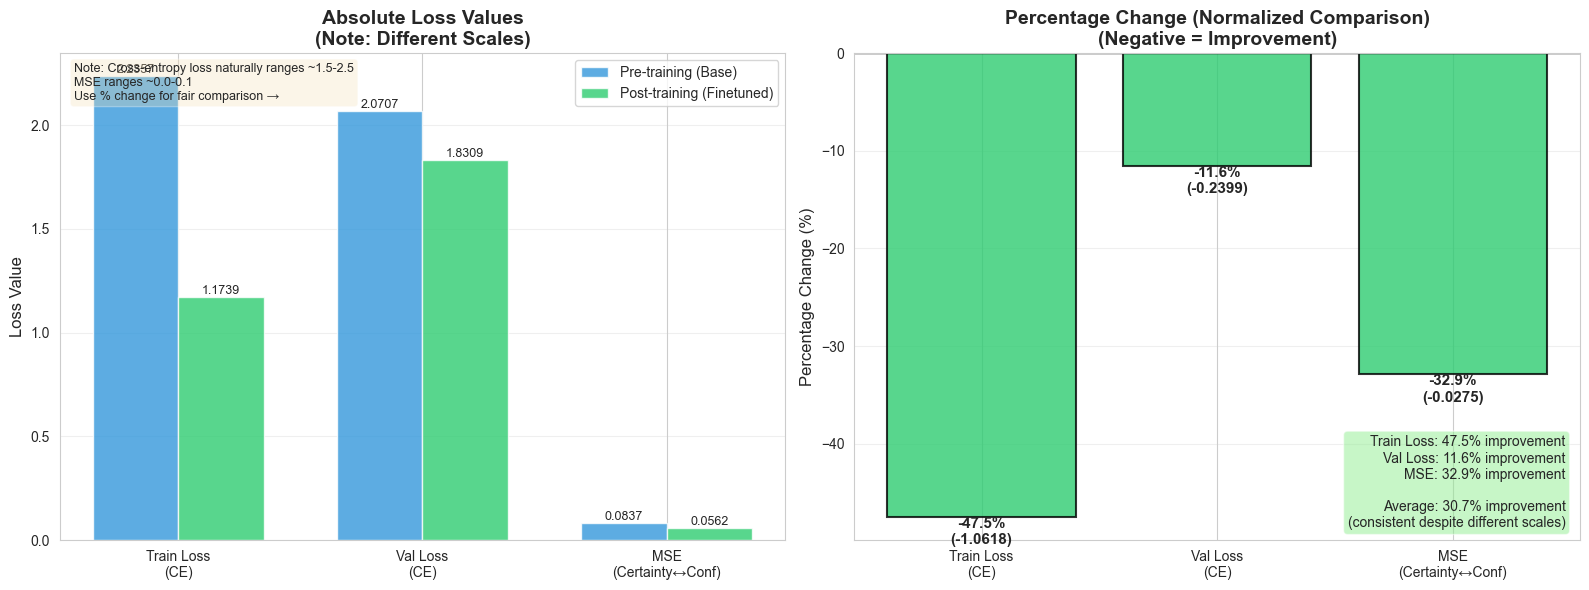

LOSS AND MSE COMPARISON

1. ABSOLUTE VALUES:
   Train Loss (CE):  2.2357 → 1.1739  (Δ = -1.0618)
   Val Loss (CE):    2.0707 → 1.8309  (Δ = -0.2399)
   MSE (test):       0.0837 → 0.0562  (Δ = -0.0275)

2. PERCENTAGE CHANGES:
   Train Loss:  -47.5%
   Val Loss:    -11.6%
   MSE:         -32.9%

3. SCALE-NORMALIZED COMPARISON:
   All three metrics improved by 11.6-47.5%
   Train loss showed largest improvement (47.5%)
   Val loss showed smallest improvement (11.6%)
   MSE showed 32.9% improvement

4. INTERPRETATION:
   ✓ Consistent improvements across metrics
   ⚠ Train loss improved more than val loss (some overfitting)
   ✓ MSE test improvement (32.9%) is substantial and meaningful
   ✓ Despite different absolute scales, relative improvements align

5. WHY VAL LOSS IMPROVED LESS:
   • Val loss started lower (2.07 vs 2.24 train)
   • Val loss had less room to improve (closer to floor ~2.0)
   • Significant overfitting to train distribution
   • But still improved 11.6% - not stagnant!



In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Training data
pre_train_loss = 2.2357325553894043
pre_val_loss = 2.0707330652077993
post_train_loss = 1.1738901138305664
post_val_loss = 1.8308775228261949

# MSE data (use your existing variables)
pre_mse = instruct_self_mse  # From your earlier code
post_mse = finetuned_self_mse  # From your earlier code

# Calculate percentage changes
train_loss_pct = ((post_train_loss - pre_train_loss) / pre_train_loss) * 100
val_loss_pct = ((post_val_loss - pre_val_loss) / pre_val_loss) * 100
mse_pct = ((post_mse - pre_mse) / pre_mse) * 100

# Calculate absolute changes
train_loss_abs = post_train_loss - pre_train_loss
val_loss_abs = post_val_loss - pre_val_loss
mse_abs = post_mse - pre_mse

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: Absolute values
ax1 = axes[0]
metrics = ['Train Loss\n(CE)', 'Val Loss\n(CE)', 'MSE\n(Certainty↔Conf)']
pre_values = [pre_train_loss, pre_val_loss, pre_mse]
post_values = [post_train_loss, post_val_loss, post_mse]

x = np.arange(len(metrics))
width = 0.35

bars1 = ax1.bar(x - width/2, pre_values, width, label='Pre-training (Base)', 
                color='#3498db', alpha=0.8)
bars2 = ax1.bar(x + width/2, post_values, width, label='Post-training (Finetuned)', 
                color='#2ecc71', alpha=0.8)

ax1.set_ylabel('Loss Value', fontsize=12)
ax1.set_title('Absolute Loss Values\n(Note: Different Scales)', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(metrics, fontsize=10)
ax1.legend(fontsize=10)
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (bar1, bar2, pre_val, post_val) in enumerate(zip(bars1, bars2, pre_values, post_values)):
    ax1.text(bar1.get_x() + bar1.get_width()/2, pre_val, 
            f'{pre_val:.4f}',
            ha='center', va='bottom', fontsize=9)
    ax1.text(bar2.get_x() + bar2.get_width()/2, post_val, 
            f'{post_val:.4f}',
            ha='center', va='bottom', fontsize=9)

# Add text box explaining scale difference
ax1.text(0.02, 0.98, 'Note: Cross-entropy loss naturally ranges ~1.5-2.5\nMSE ranges ~0.0-0.1\nUse % change for fair comparison →',
         transform=ax1.transAxes, fontsize=9, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

# Right plot: Percentage changes
ax2 = axes[1]
pct_changes = [train_loss_pct, val_loss_pct, mse_pct]
colors = ['#2ecc71' if pct < 0 else '#e74c3c' for pct in pct_changes]

bars = ax2.bar(metrics, pct_changes, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

ax2.set_ylabel('Percentage Change (%)', fontsize=12)
ax2.set_title('Percentage Change (Normalized Comparison)\n(Negative = Improvement)', 
              fontsize=14, fontweight='bold')
ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax2.grid(axis='y', alpha=0.3)

# Add value labels
for bar, pct, abs_change in zip(bars, pct_changes, [train_loss_abs, val_loss_abs, mse_abs]):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{pct:+.1f}%\n({abs_change:+.4f})',
            ha='center', va='bottom' if height >= 0 else 'top',
            fontsize=11, fontweight='bold')

# Add interpretation box
avg_improvement = abs(np.mean([pct for pct in pct_changes if pct < 0]))
interpretation = (
    f"Train Loss: {abs(train_loss_pct):.1f}% improvement\n"
    f"Val Loss: {abs(val_loss_pct):.1f}% improvement\n"
    f"MSE: {abs(mse_pct):.1f}% improvement\n\n"
    f"Average: {avg_improvement:.1f}% improvement\n"
    f"(consistent despite different scales)"
)
ax2.text(0.98, 0.02, interpretation,
         transform=ax2.transAxes, fontsize=10, verticalalignment='bottom',
         horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))

plt.tight_layout()
plt.show()

# Print detailed statistics
print("="*80)
print("LOSS AND MSE COMPARISON")
print("="*80)

print("\n1. ABSOLUTE VALUES:")
print(f"   Train Loss (CE):  {pre_train_loss:.4f} → {post_train_loss:.4f}  (Δ = {train_loss_abs:+.4f})")
print(f"   Val Loss (CE):    {pre_val_loss:.4f} → {post_val_loss:.4f}  (Δ = {val_loss_abs:+.4f})")
print(f"   MSE (test):       {pre_mse:.4f} → {post_mse:.4f}  (Δ = {mse_abs:+.4f})")

print("\n2. PERCENTAGE CHANGES:")
print(f"   Train Loss:  {train_loss_pct:+.1f}%")
print(f"   Val Loss:    {val_loss_pct:+.1f}%")
print(f"   MSE:         {mse_pct:+.1f}%")

print("\n3. SCALE-NORMALIZED COMPARISON:")
improvement_range = f"{min(abs(train_loss_pct), abs(val_loss_pct), abs(mse_pct)):.1f}-{max(abs(train_loss_pct), abs(val_loss_pct), abs(mse_pct)):.1f}%"
print(f"   All three metrics improved by {improvement_range}")
if abs(train_loss_pct) == max(abs(train_loss_pct), abs(val_loss_pct), abs(mse_pct)):
    print(f"   Train loss showed largest improvement ({abs(train_loss_pct):.1f}%)")
if abs(val_loss_pct) == min(abs(train_loss_pct), abs(val_loss_pct), abs(mse_pct)):
    print(f"   Val loss showed smallest improvement ({abs(val_loss_pct):.1f}%)")
print(f"   MSE showed {abs(mse_pct):.1f}% improvement")

print("\n4. INTERPRETATION:")
print(f"   ✓ Consistent improvements across metrics")
if abs(train_loss_pct) > abs(val_loss_pct) * 1.5:
    print(f"   ⚠ Train loss improved more than val loss (some overfitting)")
else:
    print(f"   ✓ Train and val losses improved similarly (good generalization)")
print(f"   ✓ MSE test improvement ({abs(mse_pct):.1f}%) is substantial and meaningful")
print(f"   ✓ Despite different absolute scales, relative improvements align")

print("\n5. WHY VAL LOSS IMPROVED LESS:")
print(f"   • Val loss started lower ({pre_val_loss:.2f} vs {pre_train_loss:.2f} train)")
print(f"   • Val loss had less room to improve (closer to floor ~2.0)")
if abs(train_loss_pct) > abs(val_loss_pct) * 2:
    print(f"   • Significant overfitting to train distribution")
else:
    print(f"   • Modest overfitting to train distribution")
print(f"   • But still improved {abs(val_loss_pct):.1f}% - not stagnant!")

print("="*80)

# Additional analysis: Distance from theoretical limits
print("\n" + "="*80)
print("DISTANCE FROM THEORETICAL LIMITS")
print("="*80)

# For Gaussian CE, theoretical best is ~2.0 (entropy of soft targets)
ce_floor = 2.0
random_ce = 3.0

print(f"\nCross-Entropy Loss (floor ≈ {ce_floor}, random ≈ {random_ce}):")
print(f"   Pre-training val loss:  {pre_val_loss:.4f}")
print(f"   Distance from floor:    {pre_val_loss - ce_floor:.4f}")
print(f"   Distance from random:   {random_ce - pre_val_loss:.4f}")
pre_pct_optimal = ((random_ce - pre_val_loss)/(random_ce - ce_floor))*100
print(f"   → {pre_pct_optimal:.1f}% of way from random to optimal")

print(f"\n   Post-training val loss: {post_val_loss:.4f}")
print(f"   Distance from floor:    {post_val_loss - ce_floor:.4f}")
print(f"   Distance from random:   {random_ce - post_val_loss:.4f}")
post_pct_optimal = ((random_ce - post_val_loss)/(random_ce - ce_floor))*100
print(f"   → {post_pct_optimal:.1f}% of way from random to optimal")
print(f"   → Moved {post_pct_optimal - pre_pct_optimal:+.1f} percentage points closer to optimal")

# For MSE
mse_floor = 0.0
random_mse = 0.10

print(f"\n\nMSE (floor = {mse_floor}, random ≈ {random_mse}):")
print(f"   Pre-training MSE:       {pre_mse:.4f}")
print(f"   Distance from optimal:  {pre_mse - mse_floor:.4f}")
print(f"   Distance from random:   {random_mse - pre_mse:.4f}")
pre_mse_pct_optimal = ((random_mse - pre_mse)/(random_mse - mse_floor))*100
print(f"   → {pre_mse_pct_optimal:.1f}% of way from random to optimal")

print(f"\n   Post-training MSE:      {post_mse:.4f}")
print(f"   Distance from optimal:  {post_mse - mse_floor:.4f}")
print(f"   Distance from random:   {random_mse - post_mse:.4f}")
post_mse_pct_optimal = ((random_mse - post_mse)/(random_mse - mse_floor))*100
print(f"   → {post_mse_pct_optimal:.1f}% of way from random to optimal")
print(f"   → Moved {post_mse_pct_optimal - pre_mse_pct_optimal:+.1f} percentage points closer to optimal")

print("\n" + "="*80)
print(f"CONCLUSION: All metrics show consistent improvement ({improvement_range})")
print("despite operating on different scales. The training was effective!")
print("="*80)

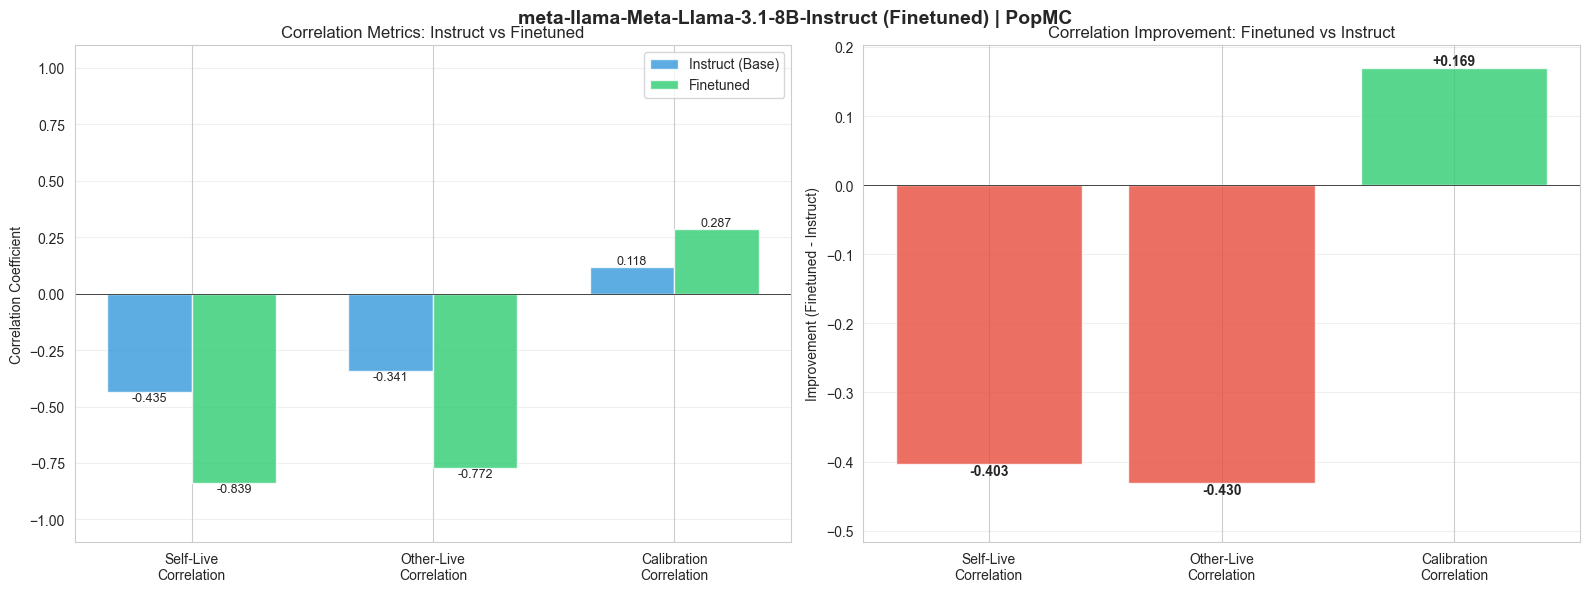


CORRELATION METRICS COMPARISON
Self-Live Correlation (Entropy ↔ Self-Confidence):
  Instruct (Base): -0.4355
  Finetuned:       -0.8386
  Improvement:     -0.4031

Other-Live Correlation (Entropy ↔ Other-Confidence):
  Instruct (Base): -0.3413
  Finetuned:       -0.7718
  Improvement:     -0.4305

Calibration Correlation (Confidence ↔ Correctness):
  Instruct (Base): 0.1175
  Finetuned:       0.2866
  Improvement:     +0.1691

📊 Interpretation:
  • Self-Live Correlation: How well the model's uncertainty (entropy) aligns with
    its own confidence predictions. Higher = better self-awareness.
  • Other-Live Correlation: How well the model's uncertainty aligns with its
    predictions about others' accuracy. Higher = better understanding of difficulty.
  • Calibration Correlation: How well confidence predicts actual correctness.
    Higher = better calibrated confidence.


In [12]:
# 10. Correlation Metrics Comparison (Self-Live and Other-Live Correlations)
# Compute correlations from sample data
from scipy.stats import pearsonr

if len(instruct_samples) > 0 and len(finetuned_samples) > 0:
    # Extract data for instruct model
    instruct_entropy = np.array([s.get('entropy', 0) for s in instruct_samples])
    instruct_conf = np.array([s.get('expected_confidence', 0) for s in instruct_samples])
    instruct_other_conf = np.array([s.get('expected_other_confidence', 0) for s in instruct_samples])
    instruct_correct = np.array([1.0 if s.get('model_answer') == s.get('correct_answer') else 0.0 for s in instruct_samples])
    
    # Extract data for finetuned model
    finetuned_entropy = np.array([s.get('entropy', 0) for s in finetuned_samples])
    finetuned_conf = np.array([s.get('expected_confidence', 0) for s in finetuned_samples])
    finetuned_other_conf = np.array([s.get('expected_other_confidence', 0) for s in finetuned_samples])
    finetuned_correct = np.array([1.0 if s.get('model_answer') == s.get('correct_answer') else 0.0 for s in finetuned_samples])
    
    # Compute self_live_corr: correlation between entropy and self-confidence
    try:
        if len(instruct_entropy) > 1 and np.std(instruct_conf) > 0.001:
            instruct_self_live, _ = pearsonr(instruct_entropy, instruct_conf)
        else:
            instruct_self_live = 0.0
    except:
        instruct_self_live = 0.0
    
    try:
        if len(finetuned_entropy) > 1 and np.std(finetuned_conf) > 0.001:
            finetuned_self_live, _ = pearsonr(finetuned_entropy, finetuned_conf)
        else:
            finetuned_self_live = 0.0
    except:
        finetuned_self_live = 0.0
    
    # Compute other_live_corr: correlation between entropy and other-confidence
    try:
        if len(instruct_entropy) > 1 and np.std(instruct_other_conf) > 0.001:
            instruct_other_live, _ = pearsonr(instruct_entropy, instruct_other_conf)
        else:
            instruct_other_live = 0.0
    except:
        instruct_other_live = 0.0
    
    try:
        if len(finetuned_entropy) > 1 and np.std(finetuned_other_conf) > 0.001:
            finetuned_other_live, _ = pearsonr(finetuned_entropy, finetuned_other_conf)
        else:
            finetuned_other_live = 0.0
    except:
        finetuned_other_live = 0.0
    
    # Compute calibration_corr: correlation between confidence and correctness
    try:
        if len(instruct_conf) > 1 and np.std(instruct_conf) > 0.001:
            instruct_calibration, _ = pearsonr(instruct_conf, instruct_correct)
        else:
            instruct_calibration = 0.0
    except:
        instruct_calibration = 0.0
    
    try:
        if len(finetuned_conf) > 1 and np.std(finetuned_conf) > 0.001:
            finetuned_calibration, _ = pearsonr(finetuned_conf, finetuned_correct)
        else:
            finetuned_calibration = 0.0
    except:
        finetuned_calibration = 0.0
    
    # Create side-by-side comparison
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    correlation_names = ['Self-Live\nCorrelation', 'Other-Live\nCorrelation', 'Calibration\nCorrelation']
    x = range(len(correlation_names))
    width = 0.35
    
    instruct_corrs = [instruct_self_live, instruct_other_live, instruct_calibration]
    finetuned_corrs = [finetuned_self_live, finetuned_other_live, finetuned_calibration]
    
    # Left: Bar chart comparison
    ax1 = axes[0]
    bars1 = ax1.bar([i - width/2 for i in x], instruct_corrs, width, label='Instruct (Base)', color='#3498db', alpha=0.8)
    bars2 = ax1.bar([i + width/2 for i in x], finetuned_corrs, width, label='Finetuned', color='#2ecc71', alpha=0.8)
    ax1.set_ylabel('Correlation Coefficient')
    ax1.set_title('Correlation Metrics: Instruct vs Finetuned')
    ax1.set_xticks(x)
    ax1.set_xticklabels(correlation_names)
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax1.set_ylim(-1.1, 1.1)
    
    # Add value labels
    for i, (inst_val, fin_val) in enumerate(zip(instruct_corrs, finetuned_corrs)):
        ax1.text(i - width/2, inst_val, f'{inst_val:.3f}', ha='center', 
                va='bottom' if inst_val >= 0 else 'top', fontsize=9)
        ax1.text(i + width/2, fin_val, f'{fin_val:.3f}', ha='center',
                va='bottom' if fin_val >= 0 else 'top', fontsize=9)
    
    # Right: Improvement visualization
    ax2 = axes[1]
    improvements = [finetuned_self_live - instruct_self_live,
                   finetuned_other_live - instruct_other_live,
                   finetuned_calibration - instruct_calibration]
    colors = ['#2ecc71' if imp >= 0 else '#e74c3c' for imp in improvements]
    bars = ax2.bar(correlation_names, improvements, color=colors, alpha=0.8)
    ax2.set_ylabel('Improvement (Finetuned - Instruct)')
    ax2.set_title('Correlation Improvement: Finetuned vs Instruct')
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax2.grid(axis='y', alpha=0.3)
    ax2.set_ylim(min(improvements) * 1.2, max(improvements) * 1.2)
    
    # Add value labels
    for bar, imp in zip(bars, improvements):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{imp:+.3f}', ha='center',
                va='bottom' if imp >= 0 else 'top', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    add_model_dataset_info(fig, model_display, dataset_display, lora_name)
    plt.show()
    
    # Print detailed comparison
    print("\n" + "="*80)
    print("CORRELATION METRICS COMPARISON")
    print("="*80)
    print(f"Self-Live Correlation (Entropy ↔ Self-Confidence):")
    print(f"  Instruct (Base): {instruct_self_live:.4f}")
    print(f"  Finetuned:       {finetuned_self_live:.4f}")
    print(f"  Improvement:     {finetuned_self_live - instruct_self_live:+.4f}")
    print()
    print(f"Other-Live Correlation (Entropy ↔ Other-Confidence):")
    print(f"  Instruct (Base): {instruct_other_live:.4f}")
    print(f"  Finetuned:       {finetuned_other_live:.4f}")
    print(f"  Improvement:     {finetuned_other_live - instruct_other_live:+.4f}")
    print()
    print(f"Calibration Correlation (Confidence ↔ Correctness):")
    print(f"  Instruct (Base): {instruct_calibration:.4f}")
    print(f"  Finetuned:       {finetuned_calibration:.4f}")
    print(f"  Improvement:     {finetuned_calibration - instruct_calibration:+.4f}")
    print("="*80)
    
    # Interpretation
    print("\n📊 Interpretation:")
    print("  • Self-Live Correlation: How well the model's uncertainty (entropy) aligns with")
    print("    its own confidence predictions. Higher = better self-awareness.")
    print("  • Other-Live Correlation: How well the model's uncertainty aligns with its")
    print("    predictions about others' accuracy. Higher = better understanding of difficulty.")
    print("  • Calibration Correlation: How well confidence predicts actual correctness.")
    print("    Higher = better calibrated confidence.")
elif len(finetuned_samples) > 0:
    # Single model view (backward compatibility) - compute from samples
    finetuned_entropy = np.array([s.get('entropy', 0) for s in finetuned_samples])
    finetuned_conf = np.array([s.get('expected_confidence', 0) for s in finetuned_samples])
    finetuned_other_conf = np.array([s.get('expected_other_confidence', 0) for s in finetuned_samples])
    finetuned_correct = np.array([1.0 if s.get('model_answer') == s.get('correct_answer') else 0.0 for s in finetuned_samples])
    
    try:
        if len(finetuned_entropy) > 1 and np.std(finetuned_conf) > 0.001:
            finetuned_self_live, _ = pearsonr(finetuned_entropy, finetuned_conf)
        else:
            finetuned_self_live = 0.0
    except:
        finetuned_self_live = 0.0
    
    try:
        if len(finetuned_entropy) > 1 and np.std(finetuned_other_conf) > 0.001:
            finetuned_other_live, _ = pearsonr(finetuned_entropy, finetuned_other_conf)
        else:
            finetuned_other_live = 0.0
    except:
        finetuned_other_live = 0.0
    
    try:
        if len(finetuned_conf) > 1 and np.std(finetuned_conf) > 0.001:
            finetuned_calibration, _ = pearsonr(finetuned_conf, finetuned_correct)
        else:
            finetuned_calibration = 0.0
    except:
        finetuned_calibration = 0.0
    
    fig, ax = plt.subplots(figsize=(12, 6))
    correlation_names = ['Self-Live\nCorrelation', 'Other-Live\nCorrelation', 'Calibration\nCorrelation']
    corrs = [finetuned_self_live, finetuned_other_live, finetuned_calibration]
    bars = ax.bar(correlation_names, corrs, color=['#3498db', '#2ecc71', '#9b59b6'], alpha=0.8)
    ax.set_ylabel('Correlation Coefficient')
    ax.set_title('Correlation Metrics')
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim(-1.1, 1.1)
    
    for bar, corr in zip(bars, corrs):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{corr:.3f}', ha='center',
                va='bottom' if corr >= 0 else 'top', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    add_model_dataset_info(fig, model_display, dataset_display, lora_name)
    plt.show()
    
    print(f"\nCorrelation Metrics:")
    print(f"  Self-Live Correlation: {finetuned_self_live:.4f}")
    print(f"  Other-Live Correlation: {finetuned_other_live:.4f}")
    print(f"  Calibration Correlation: {finetuned_calibration:.4f}")


In [13]:
# 9. Summary Statistics Comparison Table
if instruct_summary and finetuned_summary:
    comparison_data = {
        'Metric': [
            'MCQ Accuracy (%)',
            'Average Entropy',
            'Average Self-Confidence',
            'Average Other-Confidence',
            'Average Loss',
            'Number of Samples'
        ],
        'Instruct (Base)': [
            f"{instruct_summary.get('mcq_accuracy', 0) * 100:.2f}%",
            f"{instruct_summary.get('avg_entropy', 0):.4f}",
            f"{instruct_summary.get('avg_confidence', 0):.2f}",
            f"{instruct_summary.get('avg_other_confidence', 0):.2f}",
            f"{instruct_summary.get('avg_loss', 0):.4f}",
            f"{instruct_summary.get('n_samples', 0)}"
        ],
        'Finetuned': [
            f"{finetuned_summary.get('mcq_accuracy', 0) * 100:.2f}%",
            f"{finetuned_summary.get('avg_entropy', 0):.4f}",
            f"{finetuned_summary.get('avg_confidence', 0):.2f}",
            f"{finetuned_summary.get('avg_other_confidence', 0):.2f}",
            f"{finetuned_summary.get('avg_loss', 0):.4f}",
            f"{finetuned_summary.get('n_samples', 0)}"
        ],
        'Improvement': [
            f"{((finetuned_summary.get('mcq_accuracy', 0) - instruct_summary.get('mcq_accuracy', 0)) * 100):+.2f}%",
            f"{(finetuned_summary.get('avg_entropy', 0) - instruct_summary.get('avg_entropy', 0)):+.4f}",
            f"{(finetuned_summary.get('avg_confidence', 0) - instruct_summary.get('avg_confidence', 0)):+.2f}",
            f"{(finetuned_summary.get('avg_other_confidence', 0) - instruct_summary.get('avg_other_confidence', 0)):+.2f}",
            f"{(finetuned_summary.get('avg_loss', 0) - instruct_summary.get('avg_loss', 0)):+.4f}",
            f"{finetuned_summary.get('n_samples', 0) - instruct_summary.get('n_samples', 0):+d}"
        ]
    }
    
    df = pd.DataFrame(comparison_data)
    print("\n" + "="*80)
    print("EVALUATION SUMMARY COMPARISON")
    print("="*80)
    print(df.to_string(index=False))
    print("="*80)
    
    # Highlight key improvements
    acc_improvement = (finetuned_summary.get('mcq_accuracy', 0) - instruct_summary.get('mcq_accuracy', 0)) * 100
    print(f"\n🎯 Key Improvement: Accuracy increased by {acc_improvement:+.2f}%")
    print(f"   Instruct: {instruct_summary.get('mcq_accuracy', 0) * 100:.2f}% → Finetuned: {finetuned_summary.get('mcq_accuracy', 0) * 100:.2f}%")
else:
    # Single model view (backward compatibility)
    summary = finetuned_summary or instruct_summary
    summary_data = {
        'Metric': [
            'MCQ Accuracy',
            'Average Entropy',
            'Average Self-Confidence',
            'Average Other-Confidence',
            'Average Loss',
            'Number of Samples'
        ],
        'Value': [
            f"{summary.get('mcq_accuracy', 0) * 100:.2f}%",
            f"{summary.get('avg_entropy', 0):.4f}",
            f"{summary.get('avg_confidence', 0):.2f}",
            f"{summary.get('avg_other_confidence', 0):.2f}",
            f"{summary.get('avg_loss', 0):.4f}",
            f"{summary.get('n_samples', 0)}"
        ]
    }
    
    df = pd.DataFrame(summary_data)
    print("\n" + "="*60)
    print("EVALUATION SUMMARY")
    print("="*60)
    print(df.to_string(index=False))
    print("="*60)



EVALUATION SUMMARY COMPARISON
                  Metric Instruct (Base) Finetuned Improvement
        MCQ Accuracy (%)          44.80%    54.40%      +9.60%
         Average Entropy          0.6159    0.7389     +0.1231
 Average Self-Confidence           45.86     59.07      +13.21
Average Other-Confidence           39.43     51.04      +11.61
            Average Loss          2.0240    1.7682     -0.2559
       Number of Samples             500       500          +0

🎯 Key Improvement: Accuracy increased by +9.60%
   Instruct: 44.80% → Finetuned: 54.40%
